# Clustering Analysis

#### Summary of what was done

- Added tablet to desktop, so we have now two device groups: 
    - Desktop/tablet 
    - Mobile
- Aggregations per type of partner, so we have two partner groups:
    - Metasearch: Skyscanner and Kayak
    - Aggregators: Intent and MediaAlpha
- I still need to check stability across time (still not checked)

#### Discussion

- If the groups are consistent across different metrics
- In extreme cases, it's not possible that numbers will reflect your decisions
- I think we need two groupings: one for Desktop tablet and the other for Mobile. In that case we need to consider the following dimensions for each:
    - Conversion rate and value per clickout per front and back
- It's important that the country groupings will be relatively homogenous in terms of size (to avoid that most of the results will be driven by one big country in the group) - this should be a "secondary dimension"
- How exactly the matrix affects marketing activities?
- Start calculating p-values for the groupings created **TO-DO**
- I will need the project by the end of next week (before Friday 27/9)

**To-Do**

- Try another method of clustering (Gaussian Mixture Models (GMMs) or Hierarchical clustering)

- General data analysis
- Present results in a graphic way (heatmaps, etc.) - Use seaborn, etc.
- Add country names in graphs?




- Conversion rate aggregation of Meta Search and Aggregators separately (add Media Alpha to the analysis)
- Run **4 times**: 
    - Desktop/Table Front (Metasearch and Aggregator metrics)
    - Desktop/Table Back (Metasearch and Aggregator metrics)
    - Mobile Front (Metasearch and Aggregator metrics)
    - Mobile Back (Metasearch and Aggregator metrics)
    - And the same for Lastmin-flights only
        
The general idea is to understand how these grouping are stable across different sites
- Test clusters grouping stability
- Check what % we are working with (the countries we are grouping, what percentage they are of the overall)


In [3]:
!python -V

Python 3.7.6


In [12]:
!pip install tqdm

     |████████████████████████████████| 63 kB 336 kB/s eta 0:00:01


In [9]:
!pip install pandas-gbq

  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 165 kB 836 kB/s eta 0:00:01
     |████████████████████████████████| 89 kB 5.1 MB/s eta 0:00:01
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
     |████████████████████████████████| 1.3 MB 4.7 MB/s eta 0:00:01
  Using cached google_resumable_media-0.5.0-py2.py3-none-any.whl (38 kB)
     |████████████████████████████████| 70 kB 4.0 MB/s eta 0:00:01
  Using cached rsa-4.0-py2.py3-none-any.whl (38 kB)
     |████████████████████████████████| 155 kB 11.5 MB/s eta 0:00:01
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
     |████████████████████████████████| 58 kB 8.6 MB/s  eta 0:00:01
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
     |████████████████████████████████| 126 kB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 133 kB 11.6 MB/s eta 0:00:01
  Crea

### Importing modules

In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

## Dates variables for the main table query

In [5]:
start_date_timestamp = "2020-01-27 00:00:00"
end_date_timestamp = "2020-03-08 23:59:59"

## Dates variables for the sub queries

In [6]:
start_date = "2020-01-27"
end_date = "2020-03-08"

### Creating data for clustering

Step 1: Reading from the original data (z_Analyses.DataUpdated) in order to get an aggregation view per site, country, device, front/back and advertiser across main daily metrics:
- Conversions
- Clickouts
- Total value of conversions

In [7]:
# Setting environment variables
# Idan
# os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'\Users\idan\PycharmProjects\data_proj_andres\DataPOC-ed2043c59482.json' # this json file was added to the folder (Data Project july19)
# Andres
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/Users/andreslindner/Desktop/CR/t-test/data-poc-211708-bc21f092d1c5.json' 

In [10]:
# Query to create the data for clustering analysis
sql_data = """
# Creating Daily Data for Analysis - TABLE: x_Analyses.DailyDataPartners
SELECT 
  site,
  country_name,
  general_type,
  leave_behind,
  url_advertiser_details as url_advertiser_name,
  REGEXP_EXTRACT(http_request, 'vertical=([^&]*)') AS vertical,
  DATE(TIMESTAMP(http_datetime)) Date,
  SUM(IF(datadb_conversion_value > 0 ,1,0)) as Conversions,
  COUNT(*) Clickouts, 
  if(SUM(datadb_conversion_value) is null, 0,SUM(datadb_conversion_value))  ValueConversions
FROM `data-poc-211708.z_Analyses.DataUpdated` 
WHERE http_datetime >= '{start_date_timestamp}' and http_datetime <= '{end_date_timestamp}' and country_name is not null
and utm_medium like "%facebook%"
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1 ASC, 2 ASC, 3 ASC, 4 ASC, 5 ASC, 6 ASC, 7 ASC
""".format(start_date_timestamp = start_date_timestamp, end_date_timestamp = end_date_timestamp)

data = pd.read_gbq(sql_data, dialect='standard')
proj_id = 'data-poc-211708'
table_id = 'x_Analyses.DailyDataPartners'
data = data[((data['country_name'] != 'United States') & (data['url_advertiser_name'] != 'intent')) | (data['country_name'] == 'United States')]
data.to_gbq(table_id, project_id = proj_id, if_exists='replace')
data.head(20)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas_gbq/gbq.py:562: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  progress_bar_type=progress_bar_type,


site country_name general_type leave_behind url_advertiser_name vertical  \
0   45Off  Afghanistan         None        false          clicktripz   hotels   
1   45Off  Afghanistan         None        false          clicktripz   hotels   
2   45Off  Afghanistan         None        false               kayak  flights   
3   45Off  Afghanistan         None        false               kayak  flights   
4   45Off  Afghanistan         None         true          skyscanner  flights   
5   45Off  Afghanistan     Computer        false          clicktripz   hotels   
16  45Off  Afghanistan     Computer        false               kayak     cars   
17  45Off  Afghanistan     Computer        false               kayak     cars   
18  45Off  Afghanistan     Computer         true          clicktripz   hotels   
19  45Off  Afghanistan     Computer         true          clicktripz   hotels   
20  45Off  Afghanistan     Computer         true          clicktripz   hotels   
21  45Off  Afghanistan     Computer         true          clicktripz   hotels   
22  45Off  Afghanistan     Computer         true          clicktripz   hotels   
23  45Off  Afghanistan     Computer         true          clicktripz   hotels   
24  45Off  Afghanistan     Computer         true          clicktripz   hotels   
25  45Off  Afghanistan     Computer         true          clicktripz   hotels   
26  45Off  Afghanistan     Computer         true          clicktripz   hotels   
27  45Off  Afghanistan     Computer         true          clicktripz   hotels   
28  45Off  Afghanistan     Computer         true      hotelscombined   hotels   
29  45Off  Afghanistan     Computer         true          mediaalpha   hotels   

         Date  Conversions  Clickouts  ValueConversions  
0  2020-03-06            1          1            0.0665  
1  2020-03-07            0          1            0.0000  
2  2020-03-06            0          6            0.0000  
3  2020-03-07            0          1            0.0000  
4  2020-03-07            0          1            0.0000  
5  2020-02-05            1          1            0.9355  
16 2020-02-03            0          1            0.0000  
17 2020-02-29            0          1            0.0000  
18 2020-01-29            1          1            0.7855  
19 2020-02-01            1          1            0.7560  
20 2020-02-02            1          1            0.5310  
21 2020-02-04            1          1            0.7470  
22 2020-02-12            1          1            0.4850  
23 2020-02-17            1          1            0.2835  
24 2020-02-19            3          3            1.2155  
25 2020-02-20            1          1            0.3510  
26 2020-02-26            1          1            3.1610  
27 2020-03-05            2          2            0.7215  
28 2020-02-05            0          1            0.0000  
29 2020-02-02            0          1            0.0000

Step 2: build a data set where the analysis units are countries and the different metrics are built into features (columns)

In [13]:
# Query to create the data for clustering analysis
sql_data = """
# Creating data for Clustering Analysis
with total as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights"
GROUP BY 1,2,3
)


, total_desktop_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (general_type="Computer") AND leave_behind="false"
GROUP BY 1,2,3
)

, total_mobile_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND general_type="Mobile" AND leave_behind="false"
GROUP BY 1,2,3
)

, total_tablet_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (general_type="Tablet") AND leave_behind="false"
GROUP BY 1,2,3
)


, total_desktop_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (general_type="Computer") AND leave_behind="true"
GROUP BY 1,2,3
)

, total_mobile_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND general_type="Mobile" AND leave_behind="true"
GROUP BY 1,2,3
)

, total_tablet_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (general_type="Tablet") AND leave_behind="true"
GROUP BY 1,2,3
)



### METASEARCH ###


,metasearch as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner")
GROUP BY 1,2,3
ORDER BY 1,2,3
)


,metasearch_desktop_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner") AND (general_type="Computer") AND leave_behind="false"
GROUP BY 1,2,3
ORDER BY 1,2,3
)


,metasearch_mobile_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner") AND general_type="Mobile" AND leave_behind="false"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,metasearch_tablet_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner") AND (general_type="Tablet") AND leave_behind="false"
GROUP BY 1,2,3
ORDER BY 1,2,3
)


,metasearch_desktop_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner") AND (general_type="Computer") AND leave_behind="true"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,metasearch_mobile_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner") AND general_type="Mobile" AND leave_behind="true"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,metasearch_tablet_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name ="kayak" or url_advertiser_name ="skyscanner") AND (general_type="Tablet") AND leave_behind="true"
GROUP BY 1,2,3
ORDER BY 1,2,3
)



### AGGREGATORS ###

,aggregators as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha")
GROUP BY 1,2,3
ORDER BY 1,2,3
)


,aggregators_desktop_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha") AND (general_type="Computer") AND leave_behind="false"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,aggregators_mobile_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha") AND general_type="Mobile" AND leave_behind="false"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,aggregators_tablet_front as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha") AND (general_type="Tablet") AND leave_behind="false"
GROUP BY 1,2,3
ORDER BY 1,2,3
)


,aggregators_desktop_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha") AND (general_type="Computer") AND leave_behind="true"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,aggregators_mobile_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha") AND general_type="Mobile" AND leave_behind="true"
GROUP BY 1,2,3
ORDER BY 1,2,3
)

,aggregators_tablet_back as (
SELECT 
  site,
  country_name,
  vertical,
  SUM(Conversions) conversions,
  SUM(Clickouts) clickouts,
  SUM(ValueConversions) value_conversions,
  SUM(Conversions)/SUM(clickouts) conversion_rate
FROM `data-poc-211708.x_Analyses.DailyDataPartners` 
WHERE Date >= '{start_date}' and Date <= '{end_date}' AND vertical="flights" AND (url_advertiser_name like "intent%" or url_advertiser_name ="mediaalpha") AND (general_type="Tablet") AND leave_behind="true"
GROUP BY 1,2,3
ORDER BY 1,2,3
)




select 
  total.site site,
  total.country_name country,
  total.vertical vertical,
  total.conversions conversions,
  total.clickouts clickouts,
  total.value_conversions totalvalue,
  total.conversion_rate  conversion_rate,
  total.value_conversions/total.clickouts value_per_clickout,
  
  total_desktop_front.conversions df_conversions,
  total_desktop_front.clickouts df_clickouts,
  total_desktop_front.value_conversions df_totalvalue,
  total_desktop_front.conversion_rate  df_conversion_rate,
  total_desktop_front.value_conversions/total_desktop_front.clickouts df_value_per_clickout,
  total_mobile_front.conversions mf_conversions,
  total_mobile_front.clickouts mf_clickouts,
  total_mobile_front.value_conversions mf_totalvalue,
  total_mobile_front.conversion_rate  mf_conversion_rate,
  total_mobile_front.value_conversions/total_mobile_front.clickouts mf_value_per_clickout,
  total_tablet_front.conversions tf_conversions,
  total_tablet_front.clickouts tf_clickouts,
  total_tablet_front.value_conversions tf_totalvalue,
  total_tablet_front.conversion_rate  tf_conversion_rate,
  total_tablet_front.value_conversions/total_tablet_front.clickouts tf_value_per_clickout,
  
  total_desktop_back.conversions db_conversions,
  total_desktop_back.clickouts db_clickouts,
  total_desktop_back.value_conversions db_totalvalue,
  total_desktop_back.conversion_rate  db_conversion_rate,
  total_desktop_back.value_conversions/total_desktop_back.clickouts db_value_per_clickout,
  total_mobile_back.conversions mb_conversions,
  total_mobile_back.clickouts mb_clickouts,
  total_mobile_back.value_conversions mb_totalvalue,
  total_mobile_back.conversion_rate  mb_conversion_rate,
  total_mobile_back.value_conversions/total_mobile_back.clickouts mb_value_per_clickout,
  total_tablet_back.conversions tb_conversions,
  total_tablet_back.clickouts tb_clickouts,
  total_tablet_back.value_conversions tb_totalvalue,
  total_tablet_back.conversion_rate  tb_conversion_rate,
  total_tablet_back.value_conversions/total_tablet_back.clickouts tb_value_per_clickout,
  
  
  
  metasearch.conversions metasearch_conversions,
  metasearch.clickouts metasearch_clickouts,
  metasearch.value_conversions metasearch_totalvalue,
  metasearch.conversions/metasearch.clickouts metasearch_conversion_rate,
  metasearch.value_conversions/metasearch.clickouts metasearch_value_per_clickout,
  
  metasearch_desktop_front.conversions metasearch_df_conversions,
  metasearch_desktop_front.clickouts metasearch_df_clickouts,
  metasearch_desktop_front.value_conversions metasearch_df_totalvalue,
  metasearch_desktop_front.conversions/metasearch_desktop_front.clickouts metasearch_df_conversion_rate,
  metasearch_desktop_front.value_conversions/metasearch_desktop_front.clickouts metasearch_df_value_per_clickout,
  metasearch_mobile_front.conversions metasearch_mf_conversions,
  metasearch_mobile_front.clickouts metasearch_mf_clickouts,
  metasearch_mobile_front.value_conversions metasearch_mf_totalvalue,
  metasearch_mobile_front.conversions/metasearch_mobile_front.clickouts metasearch_mf_conversion_rate,
  metasearch_mobile_front.value_conversions/metasearch_mobile_front.clickouts metasearch_mf_value_per_clickout,
  metasearch_tablet_front.conversions metasearch_tf_conversions,
  metasearch_tablet_front.clickouts metasearch_tf_clickouts,
  metasearch_tablet_front.value_conversions metasearch_tf_totalvalue,
  metasearch_tablet_front.conversions/metasearch_tablet_front.clickouts metasearch_tf_conversion_rate,
  metasearch_tablet_front.value_conversions/metasearch_tablet_front.clickouts metasearch_tf_value_per_clickout,
  
  metasearch_desktop_back.conversions metasearch_db_conversions,
  metasearch_desktop_back.clickouts metasearch_db_clickouts,
  metasearch_desktop_back.value_conversions metasearch_db_totalvalue,
  metasearch_desktop_back.conversions/metasearch_desktop_back.clickouts metasearch_db_conversion_rate,
  metasearch_desktop_back.value_conversions/metasearch_desktop_back.clickouts metasearch_db_value_per_clickout,
  metasearch_mobile_back.conversions metasearch_mb_conversions,
  metasearch_mobile_back.clickouts metasearch_mb_clickouts,
  metasearch_mobile_back.value_conversions metasearch_mb_totalvalue,
  metasearch_mobile_back.conversions/metasearch_mobile_back.clickouts metasearch_mb_conversion_rate,
  metasearch_mobile_back.value_conversions/metasearch_mobile_back.clickouts metasearch_mb_value_per_clickout,
  metasearch_tablet_back.conversions metasearch_tb_conversions,
  metasearch_tablet_back.clickouts metasearch_tb_clickouts,
  metasearch_tablet_back.value_conversions metasearch_tb_totalvalue,
  metasearch_tablet_back.conversions/metasearch_tablet_back.clickouts metasearch_tb_conversion_rate,
  metasearch_tablet_back.value_conversions/metasearch_tablet_back.clickouts metasearch_tb_value_per_clickout,
  
  
  
  aggregators.conversions aggregators_conversions,
  aggregators.clickouts aggregators_clickouts,
  aggregators.value_conversions aggregators_totalvalue,
  aggregators.conversions/aggregators.clickouts aggregators_conversion_rate,
  aggregators.value_conversions/aggregators.clickouts aggregators_value_per_clickout,
  
  aggregators_desktop_front.conversions aggregators_df_conversions,
  aggregators_desktop_front.clickouts aggregators_df_clickouts,
  aggregators_desktop_front.value_conversions aggregators_df_totalvalue,
  aggregators_desktop_front.conversions/aggregators_desktop_front.clickouts aggregators_df_conversion_rate,
  aggregators_desktop_front.value_conversions/aggregators_desktop_front.clickouts aggregators_df_value_per_clickout,
  aggregators_mobile_front.conversions aggregators_mf_conversions,
  aggregators_mobile_front.clickouts aggregators_mf_clickouts,
  aggregators_mobile_front.value_conversions aggregators_mf_totalvalue,
  aggregators_mobile_front.conversions/aggregators_mobile_front.clickouts aggregators_mf_conversion_rate,
  aggregators_mobile_front.value_conversions/aggregators_mobile_front.clickouts aggregators_mf_value_per_clickout,
  aggregators_tablet_front.conversions aggregators_tf_conversions,
  aggregators_tablet_front.clickouts aggregators_tf_clickouts,
  aggregators_tablet_front.value_conversions aggregators_tf_totalvalue,
  aggregators_tablet_front.conversions/aggregators_tablet_front.clickouts aggregators_tf_conversion_rate,
  aggregators_tablet_front.value_conversions/aggregators_tablet_front.clickouts aggregators_tf_value_per_clickout,
  
  aggregators_desktop_back.conversions aggregators_db_conversions,
  aggregators_desktop_back.clickouts aggregators_db_clickouts,
  aggregators_desktop_back.value_conversions aggregators_db_totalvalue,
  aggregators_desktop_back.conversions/aggregators_desktop_back.clickouts aggregators_db_conversion_rate,
  aggregators_desktop_back.value_conversions/aggregators_desktop_back.clickouts aggregators_db_value_per_clickout,
  aggregators_mobile_back.conversions aggregators_mb_conversions,
  aggregators_mobile_back.clickouts aggregators_mb_clickouts,
  aggregators_mobile_back.value_conversions aggregators_mb_totalvalue,
  aggregators_mobile_back.conversions/aggregators_mobile_back.clickouts aggregators_mb_conversion_rate,
  aggregators_mobile_back.value_conversions/aggregators_mobile_back.clickouts aggregators_mb_value_per_clickout,
  aggregators_tablet_back.conversions aggregators_tb_conversions,
  aggregators_tablet_back.clickouts aggregators_tb_clickouts,
  aggregators_tablet_back.value_conversions aggregators_tb_totalvalue,
  aggregators_tablet_back.conversions/aggregators_tablet_back.clickouts aggregators_tb_conversion_rate,
  aggregators_tablet_back.value_conversions/aggregators_tablet_back.clickouts aggregators_tb_value_per_clickout
  
from
  total 
  left join metasearch using(site,country_name,vertical) 
  left join aggregators using(site,country_name,vertical) 
  
  left join total_desktop_front using(site,country_name,vertical)
  left join metasearch_desktop_front using(site,country_name,vertical) 
  left join aggregators_desktop_front using(site,country_name,vertical) 
  
  left join total_mobile_front using(site,country_name,vertical) 
  left join metasearch_mobile_front using(site,country_name,vertical) 
  left join aggregators_mobile_front using(site,country_name,vertical) 
  
  left join total_tablet_front using(site,country_name,vertical) 
  left join metasearch_tablet_front using(site,country_name,vertical) 
  left join aggregators_tablet_front using(site,country_name,vertical) 
  
  
  
  left join total_desktop_back using(site,country_name,vertical) 
  left join metasearch_desktop_back using(site,country_name,vertical) 
  left join aggregators_desktop_back using(site,country_name,vertical) 
  
  left join total_mobile_back using(site,country_name,vertical) 
  left join metasearch_mobile_back using(site,country_name,vertical) 
  left join aggregators_mobile_back using(site,country_name,vertical)
  
  left join total_tablet_back using(site,country_name,vertical) 
  left join metasearch_tablet_back using(site,country_name,vertical) 
  left join aggregators_tablet_back using(site,country_name,vertical)

""".format(start_date = start_date, end_date = end_date)

data = pd.read_gbq(sql_data, dialect='standard')
proj_id = 'data-poc-211708'
table_id = 'x_Analyses.DataForClustering'
data.to_gbq(table_id, project_id=proj_id, if_exists='replace')

In [14]:
data[data['country'] == 'United States']

site        country vertical  conversions  clickouts  \
56             45Off  United States  flights         1900      10067   
84          Tripbase  United States  flights         4251       8932   
506  Lastmin-Flights  United States  flights         7770      10847   

      totalvalue  conversion_rate  value_per_clickout  df_conversions  \
56   1651.420810         0.188735            0.164043            42.0   
84   1788.741871         0.475929            0.200262           290.0   
506  1801.894737         0.716327            0.166119           123.0   

     df_clickouts  ...  aggregators_mb_conversions  aggregators_mb_clickouts  \
56           86.0  ...                         1.0                       1.0   
84          371.0  ...                       129.0                     343.0   
506         168.0  ...                        82.0                     222.0   

     aggregators_mb_totalvalue  aggregators_mb_conversion_rate  \
56                      0.1304                        1.000000   
84                     16.9800                        0.376093   
506                    14.1500                        0.369369   

     aggregators_mb_value_per_clickout  aggregators_tb_conversions  \
56                            0.130400                         NaN   
84                            0.049504                         0.0   
506                           0.063739                         2.0   

     aggregators_tb_clickouts  aggregators_tb_totalvalue  \
56                        NaN                        NaN   
84                       40.0                       0.00   
506                      27.0                       1.45   

     aggregators_tb_conversion_rate  aggregators_tb_value_per_clickout  
56                              NaN                                NaN  
84                         0.000000                           0.000000  
506                        0.074074                           0.053704  

[3 rows x 108 columns]

### Importing data

In [15]:
# path = "/Users/andreslindner/Downloads/results-20190914-212515.csv"

# data = pd.read_csv(path)
# data

# os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/Users/andreslindner/Desktop/Cricket/DataPOC-ed2043c59482.json'

sql_data = """
    SELECT *
    FROM `data-poc-211708.x_Analyses.DataForClustering`
"""

data = pd.read_gbq(sql_data, dialect='standard')
data.shape

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas_gbq/gbq.py:562: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  progress_bar_type=progress_bar_type,


(658, 108)

In [16]:
data.columns

Index(['site', 'country', 'vertical', 'conversions', 'clickouts', 'totalvalue',
       'conversion_rate', 'value_per_clickout', 'df_conversions',
       'df_clickouts',
       ...
       'aggregators_mb_conversions', 'aggregators_mb_clickouts',
       'aggregators_mb_totalvalue', 'aggregators_mb_conversion_rate',
       'aggregators_mb_value_per_clickout', 'aggregators_tb_conversions',
       'aggregators_tb_clickouts', 'aggregators_tb_totalvalue',
       'aggregators_tb_conversion_rate', 'aggregators_tb_value_per_clickout'],
      dtype='object', length=108)

In [17]:
# Filling zero values for NaNs
data = data.fillna(0)
data

site                country vertical  conversions  clickouts  \
0              45Off                Algeria  flights          591       3341   
1              45Off              Argentina  flights        12404      45995   
2              45Off                Armenia  flights          274       1926   
3              45Off                Belarus  flights          303       2160   
4              45Off                 Canada  flights          311       1446   
..               ...                    ...      ...          ...        ...   
653  Lastmin-Flights               Slovakia  flights           46         78   
654  Lastmin-Flights  Republic of Lithuania  flights          149        262   
655            45Off             Tajikistan  flights           16        126   
656  Lastmin-Flights             Kyrgyzstan  flights          117        162   
657  Lastmin-Flights             Martinique  flights           22         45   

      totalvalue  conversion_rate  value_per_clickout  df_conversions  \
0     252.803287         0.176893            0.075667            97.0   
1    3979.646709         0.269681            0.086523           215.0   
2     120.731718         0.142264            0.062685            27.0   
3     119.899951         0.140278            0.055509            26.0   
4     224.253747         0.215076            0.155086            55.0   
..           ...              ...                 ...             ...   
653     5.719357         0.589744            0.073325             3.0   
654    14.666677         0.568702            0.055980            25.0   
655    15.367082         0.126984            0.121961             1.0   
656     9.867388         0.722222            0.060910             4.0   
657     2.162325         0.488889            0.048052             3.0   

     df_clickouts  ...  aggregators_mb_conversions  aggregators_mb_clickouts  \
0           313.0  ...                         0.0                       0.0   
1           717.0  ...                         1.0                       3.0   
2           226.0  ...                         0.0                       0.0   
3            82.0  ...                         0.0                       0.0   
4           128.0  ...                         1.0                       2.0   
..            ...  ...                         ...                       ...   
653          10.0  ...                         0.0                       0.0   
654          30.0  ...                         0.0                       0.0   
655           5.0  ...                         0.0                       0.0   
656           5.0  ...                         0.0                       0.0   
657           5.0  ...                         0.0                       0.0   

     aggregators_mb_totalvalue  aggregators_mb_conversion_rate  \
0                       0.0000                        0.000000   
1                       0.0200                        0.333333   
2                       0.0000                        0.000000   
3                       0.0000                        0.000000   
4                       0.1048                        0.500000   
..                         ...                             ...   
653                     0.0000                        0.000000   
654                     0.0000                        0.000000   
655                     0.0000                        0.000000   
656                     0.0000                        0.000000   
657                     0.0000                        0.000000   

     aggregators_mb_value_per_clickout  aggregators_tb_conversions  \
0                             0.000000                         0.0   
1                             0.006667                         1.0   
2                             0.000000                         0.0   
3                             0.000000                         0.0   
4                             0.052400                         0.0   
..  

In [19]:
# Idan
# data.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Data_Cricket_BEFORE2.csv", index=False)
# Andres
data.to_csv("/Users/andreslindner/Desktop/CR/t-test/data/Data_Cricket_BEFORE2.csv", index=False)

The idea is to use the following metrics as features for building the groupings:
- Conversions
- Clickouts
- Value of conversions
- Conversion Rate (Conversions/Clickouts)
- Value per clickout

and the same metrics for key partners in each vertical. For example, in the flights vertical, we will use **Kayak, Intent and Skyscanner** as key partners. We would like to see that the different groups perform similarly for the overall metrics but also for the partner-specific metrics.

In order to estimat the variance of the conversion rates, we will use the regular formulas for binomial distribution:

$$\hat{\sigma} = \frac{\hat{p} \cdot(1 - \hat{p})}{n} $$

I will be doing this for the general conversion rate variance, and the one for the different partners.

In [20]:
data['var_conversion_rate'] = (data['conversion_rate']*(1-data['conversion_rate']))/data['clickouts']
data['metasearch_var_conversion_rate'] = (data['metasearch_conversion_rate']*(1-data['metasearch_conversion_rate']))/data['metasearch_clickouts']
data['aggregators_var_conversion_rate'] = (data['aggregators_conversion_rate']*(1-data['aggregators_conversion_rate']))/data['aggregators_clickouts']


data['df_var_conversion_rate'] = (data['df_conversion_rate']*(1-data['df_conversion_rate']))/data['df_clickouts']
data['metasearch_df_var_conversion_rate'] = (data['metasearch_df_conversion_rate']*(1-data['metasearch_df_conversion_rate']))/data['metasearch_df_clickouts']
data['aggregators_df_var_conversion_rate'] = (data['aggregators_df_conversion_rate']*(1-data['aggregators_df_conversion_rate']))/data['aggregators_df_clickouts']

data['db_var_conversion_rate'] = (data['db_conversion_rate']*(1-data['db_conversion_rate']))/data['db_clickouts']
data['metasearch_db_var_conversion_rate'] = (data['metasearch_db_conversion_rate']*(1-data['metasearch_db_conversion_rate']))/data['metasearch_db_clickouts']
data['aggregators_db_var_conversion_rate'] = (data['aggregators_db_conversion_rate']*(1-data['aggregators_db_conversion_rate']))/data['aggregators_db_clickouts']



data['mf_var_conversion_rate'] = (data['mf_conversion_rate']*(1-data['mf_conversion_rate']))/data['mf_clickouts']
data['metasearch_mf_var_conversion_rate'] = (data['metasearch_mf_conversion_rate']*(1-data['metasearch_mf_conversion_rate']))/data['metasearch_mf_clickouts']
data['aggregators_mf_var_conversion_rate'] = (data['aggregators_mf_conversion_rate']*(1-data['aggregators_mf_conversion_rate']))/data['aggregators_mf_clickouts']

data['mb_var_conversion_rate'] = (data['mb_conversion_rate']*(1-data['mb_conversion_rate']))/data['mb_clickouts']
data['metasearch_mb_var_conversion_rate'] = (data['metasearch_mb_conversion_rate']*(1-data['metasearch_mb_conversion_rate']))/data['metasearch_mb_clickouts']
data['aggregators_mb_var_conversion_rate'] = (data['aggregators_mb_conversion_rate']*(1-data['aggregators_mb_conversion_rate']))/data['aggregators_mb_clickouts']



data['tf_var_conversion_rate'] = (data['tf_conversion_rate']*(1-data['tf_conversion_rate']))/data['tf_clickouts']
data['metasearch_tf_var_conversion_rate'] = (data['metasearch_tf_conversion_rate']*(1-data['metasearch_tf_conversion_rate']))/data['metasearch_tf_clickouts']
data['aggregators_tf_var_conversion_rate'] = (data['aggregators_tf_conversion_rate']*(1-data['aggregators_tf_conversion_rate']))/data['aggregators_tf_clickouts']

data['tb_var_conversion_rate'] = (data['tb_conversion_rate']*(1-data['tb_conversion_rate']))/data['tb_clickouts']
data['metasearch_tb_var_conversion_rate'] = (data['metasearch_tb_conversion_rate']*(1-data['metasearch_tb_conversion_rate']))/data['metasearch_tb_clickouts']
data['aggregators_tb_var_conversion_rate'] = (data['aggregators_tb_conversion_rate']*(1-data['aggregators_tb_conversion_rate']))/data['aggregators_tb_clickouts']



I will add the percentage of desktop and mobile clickouts (front) over all clickouts

In [21]:
# Adding % of df and mf clickout over all clickouts
data['percentage_df'] = data['df_clickouts']/data['clickouts']
data['percentage_mf'] = data['mf_clickouts']/data['clickouts']
data['percentage_tf'] = data['tf_clickouts']/data['clickouts']


data['percentage_db'] = data['db_clickouts']/data['clickouts']
data['percentage_mb'] = data['mb_clickouts']/data['clickouts']
data['percentage_tb'] = data['tb_clickouts']/data['clickouts']

In [22]:
data.head(10)

site             country vertical  conversions  clickouts   totalvalue  \
0  45Off             Algeria  flights          591       3341   252.803287   
1  45Off           Argentina  flights        12404      45995  3979.646709   
2  45Off             Armenia  flights          274       1926   120.731718   
3  45Off             Belarus  flights          303       2160   119.899951   
4  45Off              Canada  flights          311       1446   224.253747   
5  45Off               Chile  flights         8254      24593  2255.231599   
6  45Off            Colombia  flights         9649      37645  2794.192065   
7  45Off          Costa Rica  flights          447       2563   139.485391   
8  45Off  Dominican Republic  flights          204       1538    55.988344   
9  45Off             Ecuador  flights          641       3934   206.022934   

   conversion_rate  value_per_clickout  df_conversions  df_clickouts  ...  \
0         0.176893            0.075667            97.0         313.0  ...   
1         0.269681            0.086523           215.0         717.0  ...   
2         0.142264            0.062685            27.0         226.0  ...   
3         0.140278            0.055509            26.0          82.0  ...   
4         0.215076            0.155086            55.0         128.0  ...   
5         0.335624            0.091702           351.0         839.0  ...   
6         0.256316            0.074225           442.0        1335.0  ...   
7         0.174405            0.054423             9.0          36.0  ...   
8         0.132640            0.036403            38.0          78.0  ...   
9         0.162938            0.052370            31.0          95.0  ...   

   aggregators_tf_var_conversion_rate  tb_var_conversion_rate  \
0                            0.000000                0.005487   
1                            0.000000                0.000682   
2                                 NaN                0.000000   
3                                 NaN                0.125000   
4                            0.000624                0.004500   
5                                 NaN                0.002074   
6                                 NaN                0.000290   
7                            0.000000                0.001422   
8                            0.003188                0.013672   
9                            0.006176                0.001187   

   metasearch_tb_var_conversion_rate  aggregators_tb_var_conversion_rate  \
0                           0.005487                                 NaN   
1                           0.000673                            0.013672   
2                           0.000000                                 NaN   
3                           0.000000                            0.000000   
4                           0.006106                            0.000000   
5                           0.002074                                 NaN   
6                           0.000290                                 NaN   
7                           0.001972                            0.000000   
8                           0.013672                                 NaN   
9                           0.001187                                 NaN   

   percentage_df  percentage_mf  percentage_tf  percentage_db  percentage_mb  \
0       0.093685       0.598922       0.019455       0.099072       0.113140   
1       0.015589       0.794760       0.006196       0.015480       0.138493   
2       0.117342       0.607996       0.017653       0.116822       0.112150   
3       0.037963       0.810185       0.013889       0.038889       0.090278   
4       0.088520       0.562241       0.158368       0.088520       0.037344   
5       0.034115       0.809905       0.004554       0.034115       0.093685   
6       0.035463       0.769797       0.008793       0.035303       0.101554   
7       0.014046       0.838861       0.028482       0.013266       0.077253   
8       0.050715       0

In [23]:
data = data.fillna(0)

In [24]:
data.shape

(658, 135)

In [25]:
data.columns

Index(['site', 'country', 'vertical', 'conversions', 'clickouts', 'totalvalue',
       'conversion_rate', 'value_per_clickout', 'df_conversions',
       'df_clickouts',
       ...
       'aggregators_tf_var_conversion_rate', 'tb_var_conversion_rate',
       'metasearch_tb_var_conversion_rate',
       'aggregators_tb_var_conversion_rate', 'percentage_df', 'percentage_mf',
       'percentage_tf', 'percentage_db', 'percentage_mb', 'percentage_tb'],
      dtype='object', length=135)

I'm going to drop value per conversions, in order to avoid dealing with NaNs. However, including conversions rates and value per clickout (which don't suffer for NaNs when conversions are zero) we will be indirectly including this data in the models.

In [26]:
# data = data.drop(columns=['value_per_conversion'])
# data.columns

In [27]:
#data[data['country'] == 'Germany'].groupby(by='country').agg({'df_clickouts': 'sum', 'mf_clickouts': 'sum', 'mb_clickouts' :'sum', 'db_clickouts':'sum'})

In [28]:
data.shape

(658, 135)

In [29]:
# data.to_csv("/Users/andreslindner/Desktop/Data_Cricket_test4.csv", index=False)

------

### Aggregating data for all sites

In [30]:
data_subset = data[['country', 'vertical', 'clickouts', 'conversions', 'totalvalue', 
                    'df_clickouts', 'df_conversions', 'df_totalvalue', 
                    'db_clickouts', 'db_conversions', 'db_totalvalue', 
                    'mf_clickouts', 'mf_conversions', 'mf_totalvalue', 
                    'mb_clickouts', 'mb_conversions', 'mb_totalvalue',
                    'tf_clickouts', 'tf_conversions', 'tf_totalvalue', 
                    'tb_clickouts', 'tb_conversions', 'tb_totalvalue',
                    
                    'metasearch_clickouts', 'metasearch_clickouts','metasearch_clickouts', 'metasearch_clickouts',
                    'aggregators_clickouts', 'aggregators_clickouts','aggregators_clickouts', 'aggregators_clickouts',
                    'metasearch_df_clickouts', 'metasearch_db_clickouts','metasearch_mf_clickouts', 'metasearch_mb_clickouts','metasearch_tf_clickouts', 'metasearch_tb_clickouts',
                    'aggregators_df_clickouts', 'aggregators_db_clickouts','aggregators_mf_clickouts', 'aggregators_mb_clickouts','aggregators_tf_clickouts', 'aggregators_tb_clickouts',
                    'metasearch_df_conversions', 'metasearch_db_conversions','metasearch_mf_conversions', 'metasearch_mb_conversions','metasearch_tf_conversions', 'metasearch_tb_conversions',
                    'aggregators_df_conversions', 'aggregators_db_conversions','aggregators_mf_conversions', 'aggregators_mb_conversions','aggregators_tf_conversions', 'aggregators_tb_conversions',
                    'metasearch_df_totalvalue', 'metasearch_db_totalvalue','metasearch_mf_totalvalue', 'metasearch_mb_totalvalue','metasearch_tf_totalvalue', 'metasearch_tb_totalvalue',
                    'aggregators_df_totalvalue', 'aggregators_db_totalvalue','aggregators_mf_totalvalue', 'aggregators_mb_totalvalue','aggregators_tf_totalvalue', 'aggregators_tb_totalvalue']]
data_aggregated = data_subset.groupby(['country', 'vertical'], as_index=False).agg({"clickouts": "sum", "conversions": "sum", "totalvalue": "sum",  
                                                                                    "df_clickouts": "sum", "df_conversions": "sum", "df_totalvalue": "sum",  
                                                                                    "mf_clickouts": "sum", "mf_conversions": "sum", "mf_totalvalue": "sum",
                                                                                    "tf_clickouts": "sum", "tf_conversions": "sum", "tf_totalvalue": "sum",
                                                                                    
                                                                                    "metasearch_df_clickouts": "sum", "metasearch_df_conversions": "sum", "metasearch_df_totalvalue": "sum", 
                                                                                    "metasearch_mf_clickouts": "sum", "metasearch_mf_conversions": "sum", "metasearch_mf_totalvalue": "sum",
                                                                                    "metasearch_tf_clickouts": "sum", "metasearch_tf_conversions": "sum", "metasearch_tf_totalvalue": "sum",
                                                                                    
                                                                                    "metasearch_db_clickouts": "sum", "metasearch_db_conversions": "sum", "metasearch_db_totalvalue": "sum", 
                                                                                    "metasearch_mb_clickouts": "sum", "metasearch_mb_conversions": "sum", "metasearch_mb_totalvalue": "sum",
                                                                                    "metasearch_tb_clickouts": "sum", "metasearch_tb_conversions": "sum", "metasearch_tb_totalvalue": "sum",
                                                                                    
                                                                                    "aggregators_df_clickouts": "sum", "aggregators_df_conversions": "sum", "aggregators_df_totalvalue": "sum", 
                                                                                    "aggregators_mf_clickouts": "sum", "aggregators_mf_conversions": "sum", "aggregators_mf_totalvalue": "sum",
                                                                                    "aggregators_tf_clickouts": "sum", "aggregators_tf_conversions": "sum", "aggregators_tf_totalvalue": "sum",
                                                                                    
                                                                                    "aggregators_db_clickouts": "sum", "aggregators_db_conversions": "sum", "aggregators_db_totalvalue": "sum", 
                                                                                    "aggregators_mb_clickouts": "sum", "aggregators_mb_conversions": "sum", "aggregators_mb_totalvalue": "sum",
                                                                                    "aggregators_tb_clickouts": "sum", "aggregators_tb_conversions": "sum", "aggregators_tb_totalvalue": "sum"})


In [31]:
data_aggregated.columns

Index(['country', 'vertical', 'clickouts', 'conversions', 'totalvalue',
       'df_clickouts', 'df_conversions', 'df_totalvalue', 'mf_clickouts',
       'mf_conversions', 'mf_totalvalue', 'tf_clickouts', 'tf_conversions',
       'tf_totalvalue', 'metasearch_df_clickouts', 'metasearch_df_conversions',
       'metasearch_df_totalvalue', 'metasearch_mf_clickouts',
       'metasearch_mf_conversions', 'metasearch_mf_totalvalue',
       'metasearch_tf_clickouts', 'metasearch_tf_conversions',
       'metasearch_tf_totalvalue', 'metasearch_db_clickouts',
       'metasearch_db_conversions', 'metasearch_db_totalvalue',
       'metasearch_mb_clickouts', 'metasearch_mb_conversions',
       'metasearch_mb_totalvalue', 'metasearch_tb_clickouts',
       'metasearch_tb_conversions', 'metasearch_tb_totalvalue',
       'aggregators_df_clickouts', 'aggregators_df_conversions',
       'aggregators_df_totalvalue', 'aggregators_mf_clickouts',
       'aggregators_mf_conversions', 'aggregators_mf_totalvalue',

In [32]:
data_aggregated['conversion_rate'] = data_aggregated['conversions']/data_aggregated['clickouts']
data_aggregated['value_per_clickout'] = data_aggregated['totalvalue']/data_aggregated['clickouts']


data_aggregated['metasearch_df_conversion_rate'] = data_aggregated['metasearch_df_conversions']/data_aggregated['metasearch_df_clickouts']
data_aggregated['metasearch_df_value_per_clickout'] = data_aggregated['metasearch_df_totalvalue']/data_aggregated['metasearch_df_clickouts']
data_aggregated['metasearch_mf_conversion_rate'] = data_aggregated['metasearch_mf_conversions']/data_aggregated['metasearch_mf_clickouts']
data_aggregated['metasearch_mf_value_per_clickout'] = data_aggregated['metasearch_mf_totalvalue']/data_aggregated['metasearch_mf_clickouts']
data_aggregated['metasearch_tf_conversion_rate'] = data_aggregated['metasearch_tf_conversions']/data_aggregated['metasearch_tf_clickouts']
data_aggregated['metasearch_tf_value_per_clickout'] = data_aggregated['metasearch_tf_totalvalue']/data_aggregated['metasearch_tf_clickouts']

data_aggregated['metasearch_db_conversion_rate'] = data_aggregated['metasearch_db_conversions']/data_aggregated['metasearch_db_clickouts']
data_aggregated['metasearch_db_value_per_clickout'] = data_aggregated['metasearch_db_totalvalue']/data_aggregated['metasearch_db_clickouts']
data_aggregated['metasearch_mb_conversion_rate'] = data_aggregated['metasearch_mb_conversions']/data_aggregated['metasearch_mb_clickouts']
data_aggregated['metasearch_mb_value_per_clickout'] = data_aggregated['metasearch_mb_totalvalue']/data_aggregated['metasearch_mb_clickouts']
data_aggregated['metasearch_tb_conversion_rate'] = data_aggregated['metasearch_tb_conversions']/data_aggregated['metasearch_tb_clickouts']
data_aggregated['metasearch_tb_value_per_clickout'] = data_aggregated['metasearch_tb_totalvalue']/data_aggregated['metasearch_tb_clickouts']



data_aggregated['aggregators_df_conversion_rate'] = data_aggregated['aggregators_df_conversions']/data_aggregated['aggregators_df_clickouts']
data_aggregated['aggregators_df_value_per_clickout'] = data_aggregated['aggregators_df_totalvalue']/data_aggregated['aggregators_df_clickouts']
data_aggregated['aggregators_mf_conversion_rate'] = data_aggregated['aggregators_mf_conversions']/data_aggregated['aggregators_mf_clickouts']
data_aggregated['aggregators_mf_value_per_clickout'] = data_aggregated['aggregators_mf_totalvalue']/data_aggregated['aggregators_mf_clickouts']
data_aggregated['aggregators_tf_conversion_rate'] = data_aggregated['aggregators_tf_conversions']/data_aggregated['aggregators_tf_clickouts']
data_aggregated['aggregators_tf_value_per_clickout'] = data_aggregated['aggregators_tf_totalvalue']/data_aggregated['aggregators_tf_clickouts']

data_aggregated['aggregators_db_conversion_rate'] = data_aggregated['aggregators_db_conversions']/data_aggregated['aggregators_db_clickouts']
data_aggregated['aggregators_db_value_per_clickout'] = data_aggregated['aggregators_db_totalvalue']/data_aggregated['aggregators_db_clickouts']
data_aggregated['aggregators_mb_conversion_rate'] = data_aggregated['aggregators_mb_conversions']/data_aggregated['aggregators_mb_clickouts']
data_aggregated['aggregators_mb_value_per_clickout'] = data_aggregated['aggregators_mb_totalvalue']/data_aggregated['aggregators_mb_clickouts']
data_aggregated['aggregators_tb_conversion_rate'] = data_aggregated['aggregators_tb_conversions']/data_aggregated['aggregators_tb_clickouts']
data_aggregated['aggregators_tb_value_per_clickout'] = data_aggregated['aggregators_tb_totalvalue']/data_aggregated['aggregators_tb_clickouts']



data_aggregated['percentage_df'] = data_aggregated['df_clickouts']/data_aggregated['clickouts']
data_aggregated['percentage_mf'] = data_aggregated['mf_clickouts']/data_aggregated['clickouts']
data_aggregated['percentage_tf'] = data_aggregated['tf_clickouts']/data_aggregated['clickouts']

In [33]:
data_aggregated.shape

(228, 79)

In [34]:
data_aggregated.head()

country vertical  clickouts  conversions  totalvalue  df_clickouts  \
0     Afghanistan  flights        193           41   11.665127           9.0   
1         Albania  flights        646          201   41.376002          42.0   
2         Algeria  flights       4802         1264  317.611462         401.0   
3  American Samoa  flights          6            5    1.114000           1.0   
4         Andorra  flights        123           37   10.545369           4.0   

   df_conversions  df_totalvalue  mf_clickouts  mf_conversions  ...  \
0             5.0       2.522000         124.0            31.0  ...   
1            18.0       5.303000         483.0           164.0  ...   
2           104.0      56.292528        3016.0           981.0  ...   
3             1.0       0.200000           4.0             4.0  ...   
4             3.0       0.760000         100.0            28.0  ...   

   aggregators_tf_value_per_clickout  aggregators_db_conversion_rate  \
0                                NaN                        0.125000   
1                           0.000000                        0.208333   
2                           0.015294                        0.214286   
3                                NaN                        0.000000   
4                           0.027200                             NaN   

   aggregators_db_value_per_clickout  aggregators_mb_conversion_rate  \
0                           0.023750                        0.000000   
1                           0.031667                        0.571429   
2                           0.040000                        0.407407   
3                           0.000000                             NaN   
4                                NaN                             NaN   

   aggregators_mb_value_per_clickout  aggregators_tb_conversion_rate  \
0                           0.000000                             NaN   
1                           0.021429                             NaN   
2                           0.016296                             NaN   
3                                NaN                             NaN   
4                                NaN                             NaN   

   aggregators_tb_value_per_clickout  percentage_df  percentage_mf  \
0                                NaN       0.046632       0.642487   
1                                NaN       0.065015       0.747678   
2                                NaN       0.083507       0.628072   
3                                NaN       0.166667       0.666667   
4                                NaN       0.032520       0.813008   

   percentage_tf  
0       0.020725  
1       0.021672  
2       0.017076  
3       0.000000  
4       0.065041  

[5 rows x 79 columns]

In [35]:
data_aggregated.columns

Index(['country', 'vertical', 'clickouts', 'conversions', 'totalvalue',
       'df_clickouts', 'df_conversions', 'df_totalvalue', 'mf_clickouts',
       'mf_conversions', 'mf_totalvalue', 'tf_clickouts', 'tf_conversions',
       'tf_totalvalue', 'metasearch_df_clickouts', 'metasearch_df_conversions',
       'metasearch_df_totalvalue', 'metasearch_mf_clickouts',
       'metasearch_mf_conversions', 'metasearch_mf_totalvalue',
       'metasearch_tf_clickouts', 'metasearch_tf_conversions',
       'metasearch_tf_totalvalue', 'metasearch_db_clickouts',
       'metasearch_db_conversions', 'metasearch_db_totalvalue',
       'metasearch_mb_clickouts', 'metasearch_mb_conversions',
       'metasearch_mb_totalvalue', 'metasearch_tb_clickouts',
       'metasearch_tb_conversions', 'metasearch_tb_totalvalue',
       'aggregators_df_clickouts', 'aggregators_df_conversions',
       'aggregators_df_totalvalue', 'aggregators_mf_clickouts',
       'aggregators_mf_conversions', 'aggregators_mf_totalvalue',

-----

Separating data per vertical:
- Flights
- Hotels
- Cars

But we will have to build different clusters for different sites, e.g. for Flights we have:
- 45Off
- Lastmin-Flights
- Tripbase


In [36]:
set(data['site'])

{'45Off', 'Lastmin-Flights', 'Tripbase'}

### Dividing data for different sites and volumes

For each site, the idea is to divide all countries into 3 categories:
1. Countries with very high volume, meaning that that they should be analyzed on their own
2. Countries that have enough volumn to be able to be analyzed
3. Countries with very low volume which cannot be analyzed (fewer than 5 average daily conversions)

In [37]:
data_allsites = data_aggregated.copy()

In [38]:
# Calculating Variance
data_allsites['var_conversion_rate'] = (data_allsites['conversion_rate']*(1-data_allsites['conversion_rate']))/data_allsites['clickouts']

data_allsites['df_conversion_rate'] = data_allsites['df_conversions'] / data_allsites['df_clickouts']
data_allsites['mf_conversion_rate'] = data_allsites['mf_conversions'] / data_allsites['mf_clickouts']
data_allsites['tf_conversion_rate'] = data_allsites['tf_conversions'] / data_allsites['tf_clickouts']

data_allsites['var_df_conversion_rate'] = (data_allsites['df_conversion_rate']*(1-data_allsites['df_conversion_rate']))/data_allsites['df_clickouts']
data_allsites['var_mf_conversion_rate'] = (data_allsites['mf_conversion_rate']*(1-data_allsites['mf_conversion_rate']))/data_allsites['mf_clickouts']
data_allsites['var_tf_conversion_rate'] = (data_allsites['tf_conversion_rate']*(1-data_allsites['tf_conversion_rate']))/data_allsites['tf_clickouts']


In [39]:
data_allsites.head(100)

country vertical  clickouts  conversions   totalvalue  \
0      Afghanistan  flights        193           41    11.665127   
1          Albania  flights        646          201    41.376002   
2          Algeria  flights       4802         1264   317.611462   
3   American Samoa  flights          6            5     1.114000   
4          Andorra  flights        123           37    10.545369   
..             ...      ...        ...          ...          ...   
95           India  flights      36059         9159  1600.575668   
96       Indonesia  flights       1138          287    58.713547   
97            Iran  flights          9            2     1.886016   
98            Iraq  flights       1154          340    54.977064   
99         Ireland  flights        767          204    80.318032   

    df_clickouts  df_conversions  df_totalvalue  mf_clickouts  mf_conversions  \
0            9.0             5.0       2.522000         124.0            31.0   
1           42.0            18.0       5.303000         483.0           164.0   
2          401.0           104.0      56.292528        3016.0           981.0   
3            1.0             1.0       0.200000           4.0             4.0   
4            4.0             3.0       0.760000         100.0            28.0   
..           ...             ...            ...           ...             ...   
95         240.0            93.0      29.646043       24105.0          5640.0   
96          39.0            11.0       7.014000         768.0           215.0   
97           1.0             0.0       0.000000           7.0             1.0   
98          42.0            22.0       6.638400         901.0           295.0   
99          57.0            16.0      12.560000         505.0           148.0   

    ...  percentage_df  percentage_mf  percentage_tf  var_conversion_rate  \
0   ...       0.046632       0.642487       0.020725             0.000867   
1   ...       0.065015       0.747678       0.021672             0.000332   
2   ...       0.083507       0.628072       0.017076             0.000040   
3   ...       0.166667       0.666667       0.000000             0.023148   
4   ...       0.032520       0.813008       0.065041             0.001710   
..  ...            ...            ...            ...                  ...   
95  ...       0.006656       0.668488       0.004770             0.000005   
96  ...       0.034271       0.674868       0.026362             0.000166   
97  ...       0.111111       0.777778       0.000000             0.019204   
98  ...       0.036395       0.780763       0.005199             0.000180   
99  ...       0.074316       0.658409       0.078227             0.000255   

    df_conversion_rate  mf_conversion_rate  tf_conversion_rate  \
0             0.555556            0.250000            0.250000   
1             0.428571            0.339545            0.071429   
2             0.259352            0.325265            0.243902   
3             1.000000            1.000000                 NaN   
4             0.750000            0.280000            0.500000   
..                 ...                 ...                 ...   
95            0.387500            0.233976            0.343023   
96            0.282051            0.279948            0.266667   
97            0.000000            0.142857                 NaN   
98            0.523810            0.327414            0.500000   
99            0.280702            0.293069            0.283333   

    var_df_conversion_rate  var_mf_conversion_rate  var_tf_conversion_rate  
0                 0.027435                0.001512                0.046875  
1                 0.005831                0.000464                0.004738  
2                 0.000479                0.000073                0.002249  
3                 0.000000                0.000000                     NaN  
4                 0.046875                0.002016                0.031250  
..                     ...               

In [40]:
# print(data_site1.shape)
# print(data_site2.shape)
# print(data_site3.shape)

print(data_allsites.shape)

(228, 86)


In [41]:
data_allsites.columns

Index(['country', 'vertical', 'clickouts', 'conversions', 'totalvalue',
       'df_clickouts', 'df_conversions', 'df_totalvalue', 'mf_clickouts',
       'mf_conversions', 'mf_totalvalue', 'tf_clickouts', 'tf_conversions',
       'tf_totalvalue', 'metasearch_df_clickouts', 'metasearch_df_conversions',
       'metasearch_df_totalvalue', 'metasearch_mf_clickouts',
       'metasearch_mf_conversions', 'metasearch_mf_totalvalue',
       'metasearch_tf_clickouts', 'metasearch_tf_conversions',
       'metasearch_tf_totalvalue', 'metasearch_db_clickouts',
       'metasearch_db_conversions', 'metasearch_db_totalvalue',
       'metasearch_mb_clickouts', 'metasearch_mb_conversions',
       'metasearch_mb_totalvalue', 'metasearch_tb_clickouts',
       'metasearch_tb_conversions', 'metasearch_tb_totalvalue',
       'aggregators_df_clickouts', 'aggregators_df_conversions',
       'aggregators_df_totalvalue', 'aggregators_mf_clickouts',
       'aggregators_mf_conversions', 'aggregators_mf_totalvalue',

Since we have roughly 100 countries, we can create **~12 groupings** with similar countries according to performance.

## Scaling data

### All Sites Together

In [42]:
data_allsites = data_allsites[['country', 'vertical', 'conversions', 'clickouts', 'conversion_rate', 'value_per_clickout',
                               'df_clickouts', 'df_conversions', 'mf_clickouts', 'mf_conversions', 'tf_clickouts', 'tf_conversions',
                               'metasearch_df_conversion_rate', 'metasearch_df_value_per_clickout', 
                               'metasearch_mf_conversion_rate', 'metasearch_mf_value_per_clickout',
                               'metasearch_tf_conversion_rate', 'metasearch_tf_value_per_clickout',
                               
                               'metasearch_db_conversion_rate', 'metasearch_db_value_per_clickout', 
                               'metasearch_mb_conversion_rate', 'metasearch_mb_value_per_clickout',
                               'metasearch_tb_conversion_rate', 'metasearch_tb_value_per_clickout',
                               
                               'aggregators_df_conversion_rate', 'aggregators_df_value_per_clickout', 
                               'aggregators_mf_conversion_rate', 'aggregators_mf_value_per_clickout',
                               'aggregators_tf_conversion_rate', 'aggregators_tf_value_per_clickout',
                               
                               'aggregators_db_conversion_rate', 'aggregators_db_value_per_clickout', 
                               'aggregators_mb_conversion_rate', 'aggregators_mb_value_per_clickout',
                               'aggregators_tb_conversion_rate', 'aggregators_tb_value_per_clickout',
                               
                               'var_df_conversion_rate', 'var_mf_conversion_rate', 'var_tf_conversion_rate',
                               'var_conversion_rate', 
                               'percentage_df', 'percentage_mf', 'percentage_tf']]

In [43]:
data_allsites.head()

country vertical  conversions  clickouts  conversion_rate  \
0     Afghanistan  flights           41        193         0.212435   
1         Albania  flights          201        646         0.311146   
2         Algeria  flights         1264       4802         0.263224   
3  American Samoa  flights            5          6         0.833333   
4         Andorra  flights           37        123         0.300813   

   value_per_clickout  df_clickouts  df_conversions  mf_clickouts  \
0            0.060441           9.0             5.0         124.0   
1            0.064050          42.0            18.0         483.0   
2            0.066141         401.0           104.0        3016.0   
3            0.185667           1.0             1.0           4.0   
4            0.085735           4.0             3.0         100.0   

   mf_conversions  ...  aggregators_mb_value_per_clickout  \
0            31.0  ...                           0.000000   
1           164.0  ...                           0.021429   
2           981.0  ...                           0.016296   
3             4.0  ...                                NaN   
4            28.0  ...                                NaN   

   aggregators_tb_conversion_rate  aggregators_tb_value_per_clickout  \
0                             NaN                                NaN   
1                             NaN                                NaN   
2                             NaN                                NaN   
3                             NaN                                NaN   
4                             NaN                                NaN   

   var_df_conversion_rate  var_mf_conversion_rate  var_tf_conversion_rate  \
0                0.027435                0.001512                0.046875   
1                0.005831                0.000464                0.004738   
2                0.000479                0.000073                0.002249   
3                0.000000                0.000000                     NaN   
4                0.046875                0.002016                0.031250   

   var_conversion_rate  percentage_df  percentage_mf  percentage_tf  
0             0.000867       0.046632       0.642487       0.020725  
1             0.000332       0.065015       0.747678       0.021672  
2             0.000040       0.083507       0.628072       0.017076  
3             0.023148       0.166667       0.666667       0.000000  
4             0.001710       0.032520       0.813008       0.065041  

[5 rows x 43 columns]

In [44]:
data_allsites.shape

(228, 43)

In [45]:
data_allsites_backup = data_allsites.copy()

In [46]:
data_allsites = data_allsites_backup.copy()

In [47]:
data_allsites.shape

(228, 43)

In [48]:
data_allsites.head(100)

country vertical  conversions  clickouts  conversion_rate  \
0      Afghanistan  flights           41        193         0.212435   
1          Albania  flights          201        646         0.311146   
2          Algeria  flights         1264       4802         0.263224   
3   American Samoa  flights            5          6         0.833333   
4          Andorra  flights           37        123         0.300813   
..             ...      ...          ...        ...              ...   
95           India  flights         9159      36059         0.254000   
96       Indonesia  flights          287       1138         0.252197   
97            Iran  flights            2          9         0.222222   
98            Iraq  flights          340       1154         0.294627   
99         Ireland  flights          204        767         0.265971   

    value_per_clickout  df_clickouts  df_conversions  mf_clickouts  \
0             0.060441           9.0             5.0         124.0   
1             0.064050          42.0            18.0         483.0   
2             0.066141         401.0           104.0        3016.0   
3             0.185667           1.0             1.0           4.0   
4             0.085735           4.0             3.0         100.0   
..                 ...           ...             ...           ...   
95            0.044388         240.0            93.0       24105.0   
96            0.051594          39.0            11.0         768.0   
97            0.209557           1.0             0.0           7.0   
98            0.047640          42.0            22.0         901.0   
99            0.104717          57.0            16.0         505.0   

    mf_conversions  ...  aggregators_mb_value_per_clickout  \
0             31.0  ...                           0.000000   
1            164.0  ...                           0.021429   
2            981.0  ...                           0.016296   
3              4.0  ...                                NaN   
4             28.0  ...                                NaN   
..             ...  ...                                ...   
95          5640.0  ...                           0.019304   
96           215.0  ...                           0.032973   
97             1.0  ...                                NaN   
98           295.0  ...                           0.040000   
99           148.0  ...                           0.003333   

    aggregators_tb_conversion_rate  aggregators_tb_value_per_clickout  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   
..                             ...                                ...   
95                           0.375                           0.034583   
96                           0.000                           0.000000   
97                             NaN                                NaN   
98                             NaN                                NaN   
99                           1.000                           0.170000   

    var_df_conversion_rate  var_mf_conversion_rate  var_tf_conversion_rate  \
0                 0.027435                0.001512                0.046875   
1                 0.005831                0.000464                0.004738   
2                 0.000479                0.000073                0.002249   
3                 0.000000                0.000000                     NaN   
4                 0.046875                0.002016                0.031250   
..                     ...                     ...                     ...   
95                0.000989                0.000007                0.001310   
96                0.005192                0.000262         

In [49]:
desktop_data = data_allsites[(data_allsites['df_clickouts'] < 2000) & (data_allsites['df_clickouts'] >= 100) & (data_allsites['df_conversions'] >= 15)]
print(desktop_data.shape)
desktop_data_backup = desktop_data.copy()

mobile_data = data_allsites[(data_allsites['mf_clickouts'] < 2000) & (data_allsites['mf_clickouts'] >= 100) & (data_allsites['mf_conversions'] >= 15)]
print(mobile_data.shape)
mobile_data_backup = mobile_data.copy()

tablet_data = data_allsites[(data_allsites['tf_clickouts'] < 2000) & (data_allsites['tf_clickouts'] >= 100) & (data_allsites['tf_conversions'] >= 15)]
print(tablet_data.shape)
tablet_data_backup = tablet_data.copy()
                                                                                   

(58, 43)
(115, 43)
(32, 43)


#### Scaling Desktop Data

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


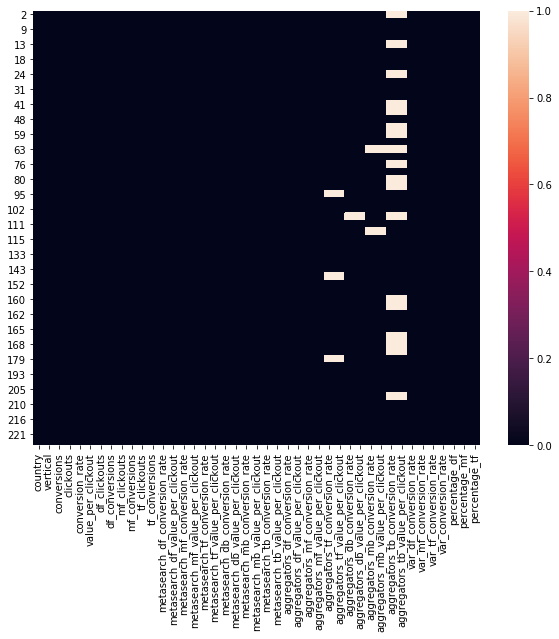

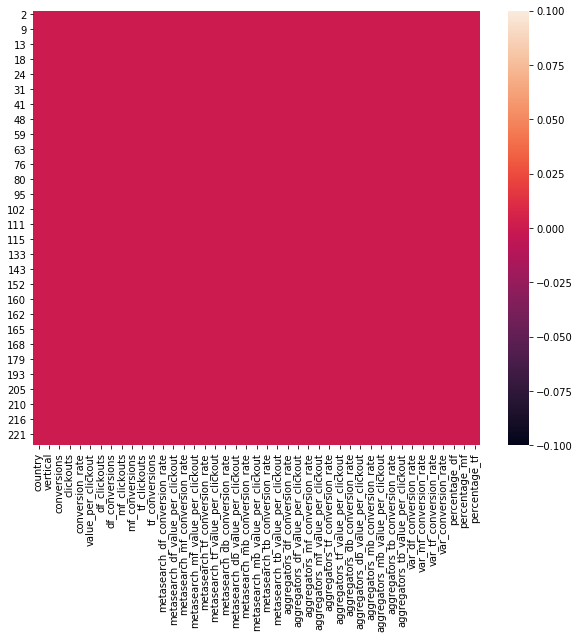

In [50]:
desktop_data[['var_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']].isnull()
plt.figure(figsize=(10,8))
sns.heatmap(data=desktop_data.isnull())
desktop_data.fillna(0, inplace=True)
plt.figure(figsize=(10,8))
sns.heatmap(data=desktop_data.isnull())

In [51]:
min_max_scaler_desktop = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(data[['conversions','clickouts','value_conversions','conversion_rate','var_conversion_rate']])
X_train_minmax_allsites_desktop = min_max_scaler_desktop.fit_transform(desktop_data[['conversions', 'clickouts', 
                                                                      'conversion_rate', 'value_per_clickout',
                                                                      'df_clickouts', 'df_conversions', 'mf_clickouts', 'mf_conversions', 'tf_clickouts', 'tf_conversions',
                                                                      'metasearch_df_conversion_rate', 'metasearch_df_value_per_clickout', 
                                                                      'metasearch_mf_conversion_rate', 'metasearch_mf_value_per_clickout',
                                                                      'metasearch_tf_conversion_rate', 'metasearch_tf_value_per_clickout',
                                                                                     
                                                                      'metasearch_db_conversion_rate', 'metasearch_db_value_per_clickout', 
                                                                      'metasearch_mb_conversion_rate', 'metasearch_mb_value_per_clickout',
                                                                      'metasearch_tb_conversion_rate', 'metasearch_tb_value_per_clickout',
                                                                                     
                                                                      'aggregators_df_conversion_rate', 'aggregators_df_value_per_clickout', 
                                                                      'aggregators_mf_conversion_rate', 'aggregators_mf_value_per_clickout',
                                                                      'aggregators_tf_conversion_rate', 'aggregators_tf_value_per_clickout',
                                                                                     
                                                                      'aggregators_db_conversion_rate', 'aggregators_db_value_per_clickout', 
                                                                      'aggregators_mb_conversion_rate', 'aggregators_mb_value_per_clickout',
                                                                      'aggregators_tb_conversion_rate', 'aggregators_tb_value_per_clickout',
                                                                                     
                                                                      'var_df_conversion_rate', 'var_mf_conversion_rate', 'var_tf_conversion_rate',
                                                                      'var_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']])


In [52]:
X_train_minmax_allsites_desktop.shape

(58, 41)

In [53]:
# data_allsites_backup = data_allsites.copy()

In [54]:
desktop_data.columns

Index(['country', 'vertical', 'conversions', 'clickouts', 'conversion_rate',
       'value_per_clickout', 'df_clickouts', 'df_conversions', 'mf_clickouts',
       'mf_conversions', 'tf_clickouts', 'tf_conversions',
       'metasearch_df_conversion_rate', 'metasearch_df_value_per_clickout',
       'metasearch_mf_conversion_rate', 'metasearch_mf_value_per_clickout',
       'metasearch_tf_conversion_rate', 'metasearch_tf_value_per_clickout',
       'metasearch_db_conversion_rate', 'metasearch_db_value_per_clickout',
       'metasearch_mb_conversion_rate', 'metasearch_mb_value_per_clickout',
       'metasearch_tb_conversion_rate', 'metasearch_tb_value_per_clickout',
       'aggregators_df_conversion_rate', 'aggregators_df_value_per_clickout',
       'aggregators_mf_conversion_rate', 'aggregators_mf_value_per_clickout',
       'aggregators_tf_conversion_rate', 'aggregators_tf_value_per_clickout',
       'aggregators_db_conversion_rate', 'aggregators_db_value_per_clickout',
       'aggregato

In [55]:
desktop_data.shape

(58, 43)

In [56]:
X_train_minmax_allsites_desktop.shape

(58, 41)

In [57]:
counter = 0

for col in desktop_data.columns[2:]:
    desktop_data[col] = X_train_minmax_allsites_desktop[:,counter]
    counter+=1


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [58]:
desktop_data.describe()

conversions  clickouts  conversion_rate  value_per_clickout  \
count    58.000000  58.000000        58.000000           58.000000   
mean      0.097706   0.101568         0.433989            0.289105   
std       0.174859   0.173768         0.198364            0.236733   
min       0.000000   0.000000         0.000000            0.000000   
25%       0.020074   0.024598         0.316534            0.143314   
50%       0.036056   0.041859         0.392728            0.212791   
75%       0.073928   0.075172         0.530239            0.337241   
max       1.000000   1.000000         1.000000            1.000000   

       df_clickouts  df_conversions  mf_clickouts  mf_conversions  \
count     58.000000       58.000000     58.000000       58.000000   
mean       0.148242        0.161122      0.098692        0.092921   
std        0.194183        0.202964      0.173771        0.177001   
min        0.000000        0.000000      0.000000        0.000000   
25%        0.023265        0.031123      0.020015        0.016041   
50%        0.085903        0.100812      0.044312        0.029231   
75%        0.177313        0.183694      0.074622        0.073718   
max        1.000000        1.000000      1.000000        1.000000   

       tf_clickouts  tf_conversions  ...  aggregators_mb_value_per_clickout  \
count     58.000000       58.000000  ...                          58.000000   
mean       0.118064        0.129223  ...                           0.173512   
std        0.181232        0.192684  ...                           0.161225   
min        0.000000        0.000000  ...                           0.000000   
25%        0.025050        0.029022  ...                           0.101786   
50%        0.053774        0.053971  ...                           0.146922   
75%        0.113560        0.129837  ...                           0.206151   
max        1.000000        1.000000  ...                           1.000000   

       aggregators_tb_conversion_rate  aggregators_tb_value_per_clickout  \
count                       58.000000                           58.00000   
mean                         0.118045                            0.09861   
std                          0.268702                            0.24225   
min                          0.000000                            0.00000   
25%                          0.000000                            0.00000   
50%                          0.000000                            0.00000   
75%                          0.091398                            0.06968   
max                          1.000000                            1.00000   

       var_df_conversion_rate  var_mf_conversion_rate  var_tf_conversion_rate  \
count               58.000000               58.000000               58.000000   
mean                 0.389662                0.141565                0.192701   
std                  0.285120                0.178374                0.207063   
min                  0.000000                0.000000                0.000000   
25%                  0.130725                0.044827                0.073560   
50%                  0.308912                0.080648                0.130399   
75%                  0.579456                0.162016                0.240376   
max                  1.000000                1.000000                1.000000   

       var_conversion_rate  percentage_df  percentage_mf  percentage_tf  
count            58.000000      58.000000      58.000000      58.000000  
mean              0.221703       0.364913       0.736214       0.119576  
std               0.227537       0.243982       0.189912       0.155366  
min               0.000000       0.000000       0.000000       0.000000  
25%               0.089760       0.159781       0.617463       0.032401  
50%               0.161936       0.283347       0.752564       0.070017  
75%               0.256238       0.553362       0.895922       0.165061  
max               1.000000       1.

#### Scaling Mobile Data

### Idan's note - Due to an error raised while trying to scale the data, I am checking for null values with a heatmap, if found, fill them with 0

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


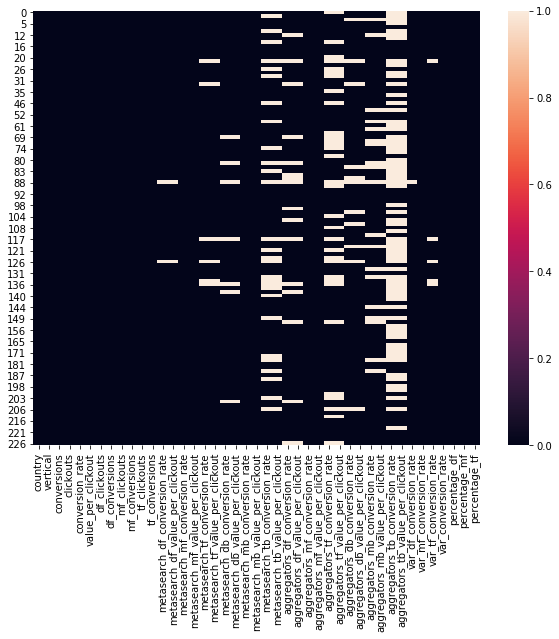

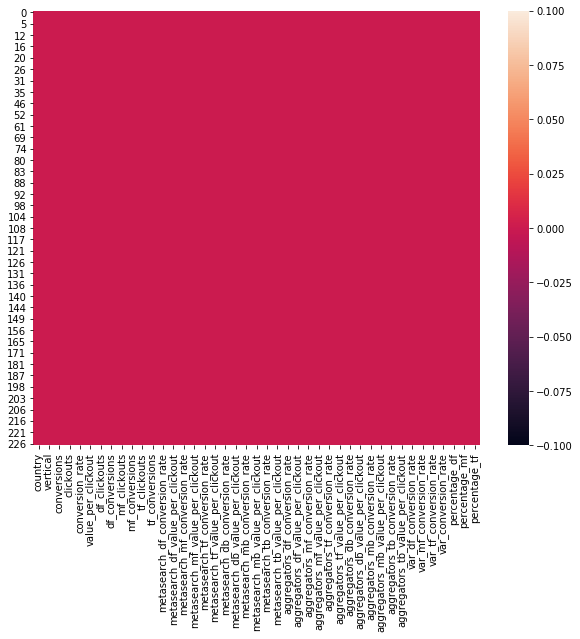

In [59]:
mobile_data[['var_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']].isnull()
plt.figure(figsize=(10,8))
sns.heatmap(data=mobile_data.isnull())
mobile_data.fillna(0, inplace=True)
plt.figure(figsize=(10,8))
sns.heatmap(data=mobile_data.isnull())

In [60]:
min_max_scaler_mobile = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(data[['conversions','clickouts','value_conversions','conversion_rate','var_conversion_rate']])
X_train_minmax_allsites_mobile = min_max_scaler_mobile.fit_transform(mobile_data[['conversions', 'clickouts', 
                                                                      'conversion_rate', 'value_per_clickout',
                                                                      'df_clickouts', 'df_conversions', 'mf_clickouts', 'mf_conversions', 'tf_clickouts', 'tf_conversions',
                                                                      'metasearch_df_conversion_rate', 'metasearch_df_value_per_clickout', 
                                                                      'metasearch_mf_conversion_rate', 'metasearch_mf_value_per_clickout',
                                                                      'metasearch_tf_conversion_rate', 'metasearch_tf_value_per_clickout',
                                                                                     
                                                                      'metasearch_db_conversion_rate', 'metasearch_db_value_per_clickout', 
                                                                      'metasearch_mb_conversion_rate', 'metasearch_mb_value_per_clickout',
                                                                      'metasearch_tb_conversion_rate', 'metasearch_tb_value_per_clickout',
                                                                                     
                                                                      'aggregators_df_conversion_rate', 'aggregators_df_value_per_clickout', 
                                                                      'aggregators_mf_conversion_rate', 'aggregators_mf_value_per_clickout',
                                                                      'aggregators_tf_conversion_rate', 'aggregators_tf_value_per_clickout',
                                                                                     
                                                                      'aggregators_db_conversion_rate', 'aggregators_db_value_per_clickout', 
                                                                      'aggregators_mb_conversion_rate', 'aggregators_mb_value_per_clickout',
                                                                      'aggregators_tb_conversion_rate', 'aggregators_tb_value_per_clickout',
                                                                                     
                                                                      'var_df_conversion_rate', 'var_mf_conversion_rate', 'var_tf_conversion_rate',
                                                                      'var_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']])


In [61]:
X_train_minmax_allsites_mobile.shape

(115, 41)

In [62]:
# data_allsites_backup = data_allsites.copy()

In [63]:
mobile_data.columns

Index(['country', 'vertical', 'conversions', 'clickouts', 'conversion_rate',
       'value_per_clickout', 'df_clickouts', 'df_conversions', 'mf_clickouts',
       'mf_conversions', 'tf_clickouts', 'tf_conversions',
       'metasearch_df_conversion_rate', 'metasearch_df_value_per_clickout',
       'metasearch_mf_conversion_rate', 'metasearch_mf_value_per_clickout',
       'metasearch_tf_conversion_rate', 'metasearch_tf_value_per_clickout',
       'metasearch_db_conversion_rate', 'metasearch_db_value_per_clickout',
       'metasearch_mb_conversion_rate', 'metasearch_mb_value_per_clickout',
       'metasearch_tb_conversion_rate', 'metasearch_tb_value_per_clickout',
       'aggregators_df_conversion_rate', 'aggregators_df_value_per_clickout',
       'aggregators_mf_conversion_rate', 'aggregators_mf_value_per_clickout',
       'aggregators_tf_conversion_rate', 'aggregators_tf_value_per_clickout',
       'aggregators_db_conversion_rate', 'aggregators_db_value_per_clickout',
       'aggregato

In [64]:
mobile_data.shape

(115, 43)

In [65]:
X_train_minmax_allsites_mobile.shape

(115, 41)

In [66]:
counter = 0

for col in mobile_data.columns[2:]:
    mobile_data[col] = X_train_minmax_allsites_mobile[:,counter]
    counter+=1


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [67]:
mobile_data.describe()

conversions   clickouts  conversion_rate  value_per_clickout  \
count   115.000000  115.000000       115.000000          115.000000   
mean      0.128326    0.140352         0.515091            0.288378   
std       0.144017    0.154356         0.189547            0.210141   
min       0.000000    0.000000         0.000000            0.000000   
25%       0.033777    0.040815         0.405312            0.159844   
50%       0.069681    0.075987         0.535026            0.219258   
75%       0.180053    0.198255         0.626581            0.320771   
max       1.000000    1.000000         1.000000            1.000000   

       df_clickouts  df_conversions  mf_clickouts  mf_conversions  \
count    115.000000      115.000000    115.000000      115.000000   
mean       0.065661        0.039653      0.261563        0.238406   
std        0.116352        0.100521      0.255119        0.222489   
min        0.000000        0.000000      0.000000        0.000000   
25%        0.013661        0.006527      0.068810        0.068056   
50%        0.034608        0.015666      0.150903        0.150000   
75%        0.062842        0.036554      0.420829        0.369444   
max        1.000000        1.000000      1.000000        1.000000   

       tf_clickouts  tf_conversions  ...  aggregators_mb_value_per_clickout  \
count    115.000000      115.000000  ...                         115.000000   
mean       0.028037        0.028991  ...                           0.236798   
std        0.097348        0.099117  ...                           0.238825   
min        0.000000        0.000000  ...                           0.000000   
25%        0.003307        0.002024  ...                           0.000000   
50%        0.010582        0.010121  ...                           0.197368   
75%        0.022487        0.024291  ...                           0.377863   
max        1.000000        1.000000  ...                           1.000000   

       aggregators_tb_conversion_rate  aggregators_tb_value_per_clickout  \
count                      115.000000                         115.000000   
mean                         0.074255                           0.044949   
std                          0.237618                           0.166603   
min                          0.000000                           0.000000   
25%                          0.000000                           0.000000   
50%                          0.000000                           0.000000   
75%                          0.000000                           0.000000   
max                          1.000000                           1.000000   

       var_df_conversion_rate  var_mf_conversion_rate  var_tf_conversion_rate  \
count              115.000000              115.000000              115.000000   
mean                 0.123172                0.257613                0.132850   
std                  0.181616                0.223566                0.190128   
min                  0.000000                0.000000                0.000000   
25%                  0.029776                0.073088                0.026682   
50%                  0.056460                0.201250                0.066370   
75%                  0.132990                0.384796                0.153285   
max                  1.000000                1.000000                1.000000   

       var_conversion_rate  percentage_df  percentage_mf  percentage_tf  
count           115.000000     115.000000     115.000000     115.000000  
mean              0.225296       0.343630       0.711120       0.123399  
std               0.197937       0.228528       0.147141       0.127348  
min               0.000000       0.000000       0.000000       0.000000  
25%               0.076169       0.160574       0.634878       0.052448  
50%               0.175685       0.281639       0.720592       0.090262  
75%               0.327876       0.494943       0.811093       0.170065  
max               1.000000

In [68]:
mobile_data.head()

country vertical  conversions  clickouts  conversion_rate  \
0  Afghanistan  flights     0.009574   0.012341         0.326777   
1      Albania  flights     0.094681   0.092207         0.607298   
4      Andorra  flights     0.007447   0.000000         0.577934   
5       Angola  flights     0.047340   0.042489         0.597484   
9      Armenia  flights     0.310106   0.445522         0.372941   

   value_per_clickout  df_clickouts  df_conversions  mf_clickouts  \
0            0.198331      0.008197        0.006527      0.012752   
1            0.220112      0.038251        0.023499      0.203507   
4            0.351007      0.003643        0.003916      0.000000   
5            0.158929      0.017304        0.009138      0.078640   
9            0.189737      0.280510        0.060052      0.800213   

   mf_conversions  ...  aggregators_mb_value_per_clickout  \
0        0.018056  ...                           0.000000   
1        0.202778  ...                           0.281955   
4        0.013889  ...                           0.000000   
5        0.112500  ...                           0.131579   
9        0.634722  ...                           0.578947   

   aggregators_tb_conversion_rate  aggregators_tb_value_per_clickout  \
0                             0.0                                0.0   
1                             0.0                                0.0   
4                             0.0                                0.0   
5                             0.0                                0.0   
9                             0.0                                0.0   

   var_df_conversion_rate  var_mf_conversion_rate  var_tf_conversion_rate  \
0                0.370370                0.645169                0.375000   
1                0.078717                0.172308                0.037901   
4                0.632812                0.872575                0.250000   
5                0.165330                0.399214                0.187500   
9                0.005569                0.021307                0.040735   

   var_conversion_rate  percentage_df  percentage_mf  percentage_tf  
0             0.495733       0.245954       0.657753       0.079434  
1             0.175685       0.342914       0.822537       0.083061  
4             1.000000       0.171523       0.924878       0.249279  
5             0.327266       0.275309       0.718584       0.084235  
9             0.017048       0.613017       0.600655       0.065083  

[5 rows x 43 columns]

#### Uploading 2 tables to BQ for pre processing the WCSS to decide how many clusters we will have

In [69]:
# Uploading mobile data
proj_id = 'data-poc-211708'
table_id = 'x_Analyses.mobile_data_for_cluster_preprocess'
mobile_data.to_gbq(table_id, project_id = proj_id, if_exists='replace')

In [70]:
# Uploading desktop data
proj_id = 'data-poc-211708'
table_id = 'x_Analyses.desktop_data_for_cluster_preprocess'
desktop_data.to_gbq(table_id, project_id = proj_id, if_exists='replace')

In [71]:
# Uploading tablet data
proj_id = 'data-poc-211708'
table_id = 'x_Analyses.tablet_data_for_cluster_preprocess'
desktop_data.to_gbq(table_id, project_id = proj_id, if_exists='replace')


### Cluster Analysis

**To-do**: 
- Consider eliminating the conversion metric, so that we can disregard the volume as a relevant metric for grouping) - **DONE**
- Do some PCA to do some visualization in 2 dimensions (MAYBE) (it might be better to keep the original metrics and present some of them in a 2D or 3D graph)



We will be creating **3 different groupings**, according to the following:
- According to conversions rates and value per clickout in **Desktop**
- According to conversions rates and value per clickout in **Mobile**
- According to conversions rates and value per clickout in **Tablet**

#### Clusters (Desktop)

Filter for minimum number of clickouts and conversions

In [72]:
from sklearn.cluster import KMeans


X = desktop_data[['metasearch_df_conversion_rate', 'metasearch_df_value_per_clickout', 
                  'aggregators_df_conversion_rate', 'aggregators_df_value_per_clickout',
                  'metasearch_db_conversion_rate', 'metasearch_db_value_per_clickout', 
                  'aggregators_db_conversion_rate', 'aggregators_db_value_per_clickout', 
                  'var_df_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)



In [73]:
desktop_data_backup.shape

(58, 43)

In [74]:
 kmeans.labels_.shape

(58,)

In [75]:
 kmeans.cluster_centers_ # this could be interesting to show the center instead of doing the average by myself.

array([[0.39140031, 0.25236773, 0.60422529, 0.26223058, 0.19525274,
        0.06812098, 0.91944634, 0.19554587, 0.34230027, 0.48163273,
        0.64809452, 0.18515351],
       [0.45739915, 0.324826  , 0.22218629, 0.10806815, 0.33849363,
        0.08072073, 0.61162664, 0.12008964, 0.20026531, 0.26676712,
        0.80753404, 0.03857354],
       [0.68855003, 0.33545336, 0.64028971, 0.21332231, 0.3039835 ,
        0.15055283, 0.19734199, 0.04094302, 0.91584074, 0.54124075,
        0.62707604, 0.15046257],
       [0.54454555, 0.32343751, 0.58359088, 0.20560989, 0.27735601,
        0.12875098, 0.4403499 , 0.10075377, 0.32326975, 0.59479065,
        0.57263528, 0.13103685],
       [0.76658033, 0.71616776, 0.71600866, 0.48350887, 0.27815708,
        0.13887244, 0.50151579, 0.16942747, 0.19610037, 0.31572985,
        0.80134256, 0.136032  ],
       [0.8449295 , 0.43553623, 0.47714044, 0.0924745 , 0.2165725 ,
        0.05425612, 0.34317684, 0.08133413, 0.09766366, 0.13233631,
        0.8691231 ,

In [76]:
desktop_data_backup['Clusters_Desktop'] = kmeans.labels_

In [77]:
desktop_data_backup.head(20)

country vertical  conversions  clickouts  conversion_rate  \
2              Algeria  flights         1264       4802         0.263224   
8            Argentina  flights        12995      48456         0.268181   
9              Armenia  flights          606       2650         0.228679   
11           Australia  flights         3032      14238         0.212951   
13          Azerbaijan  flights          398       1520         0.261842   
16          Bangladesh  flights          802       2714         0.295505   
18             Belarus  flights          512       2523         0.202933   
19             Belgium  flights          566       3346         0.169157   
24             Bolivia  flights          327        896         0.364955   
28              Brazil  flights          781       3935         0.198475   
31            Bulgaria  flights          357       1099         0.324841   
37              Canada  flights         1903       5795         0.328387   
41               Chile  flights         8866      25759         0.344190   
44            Colombia  flights        11315      40671         0.278208   
48          Costa Rica  flights         1000       3840         0.260417   
58  Dominican Republic  flights          765       2969         0.257663   
59             Ecuador  flights         1325       5078         0.260929   
60               Egypt  flights         1001       5361         0.186719   
63             Estonia  flights          588       1881         0.312600   
71              France  flights         1624       5752         0.282337   

    value_per_clickout  df_clickouts  df_conversions  mf_clickouts  \
2             0.066141         401.0           104.0        3016.0   
8             0.086571         991.0           299.0       38105.0   
9             0.059017         308.0            46.0        1606.0   
11            0.163244         642.0           197.0       10423.0   
13            0.058866         158.0            39.0         911.0   
16            0.062310         249.0            55.0        1638.0   
18            0.054217         103.0            42.0        1982.0   
19            0.037053         313.0           135.0        2185.0   
24            0.057381         100.0            45.0         473.0   
28            0.087260         134.0            84.0        3064.0   
31            0.070341         181.0            88.0         593.0   
37            0.192045        1098.0           766.0        1290.0   
41            0.090010         899.0           368.0       20801.0   
44            0.072676        1539.0           491.0       31275.0   
48            0.052045         118.0            60.0        3156.0   
58            0.044367         166.0            99.0        2223.0   
59            0.052838         167.0            83.0        3985.0   
60            0.072298         312.0            67.0        3850.0   
63            0.079677         214.0           108.0        1133.0   
71            0.129136         748.0           267.0        3191.0   

    mf_conversions  ...  aggregators_tb_conversion_rate  \
2            981.0  ...                             NaN   
8          11940.0  ...                        0.125000   
9            475.0  ...                        0.000000   
11          2204.0  ...                        0.159091   
13           283.0  ...                             NaN   
16           580.0  ...                        1.000000   
18           408.0  ...                        0.000000   
19           308.0  ...                        0.000000   
24           233.0  ...                             NaN   
28           563.0  ...                        0.000000   
31           230.0  ...                        0.000000   
37           334.0  ...                        0.253968   
41          8016.0  ...                             NaN   
44          9969.0  ...                             NaN   
48           878.0  ...                        0.000000   
58 

In [79]:
#desktop_data_backup.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Results - Desktop Clusters.csv", index=False)
# Idan link
# desktop_data_backup.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Results - Desktop Clusters_facebook_only.csv", index=False)
# Andres link
desktop_data_backup.to_csv("/Users/andreslindner/Desktop/CR/t-test/data/Results - Desktop Clusters_facebook_only.csv", index=False)

#### Uploading to BQ

In [80]:
# Uploading to BQ
import os
from google.cloud import bigquery

# os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'\Users\idan\PycharmProjects\data_proj_andres\DataPOC-ed2043c59482.json'

table_id = 'x_Analyses.ClustersDesktop'
proj_id = 'data-poc-211708'
desktop_data_backup.to_gbq(table_id, project_id=proj_id, if_exists='replace')

#### Clusters (Mobile)

In [81]:
from sklearn.cluster import KMeans


X = mobile_data[['metasearch_mf_conversion_rate', 'metasearch_mf_value_per_clickout', 
                  'aggregators_mf_conversion_rate', 'aggregators_mf_value_per_clickout',
#                   'metasearch_mb_conversion_rate', 'metasearch_mb_value_per_clickout', 
#                   'aggregators_mb_conversion_rate', 'aggregators_mb_value_per_clickout', 
                  'var_mf_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)



In [82]:
mobile_data_backup.shape

(115, 43)

In [83]:
 kmeans.labels_.shape

(115,)

In [84]:
mobile_data_backup['Clusters_Mobile'] = kmeans.labels_

In [85]:
mobile_data_backup

country vertical  conversions  clickouts  conversion_rate  \
0    Afghanistan  flights           41        193         0.212435   
1        Albania  flights          201        646         0.311146   
4        Andorra  flights           37        123         0.300813   
5         Angola  flights          112        364         0.307692   
9        Armenia  flights          606       2650         0.228679   
..           ...      ...          ...        ...              ...   
219   Uzbekistan  flights          232       1240         0.187097   
221    Venezuela  flights          523       2614         0.200077   
222      Vietnam  flights          137        596         0.229866   
225       Zambia  flights          142        552         0.257246   
226     Zimbabwe  flights          138        436         0.316514   

     value_per_clickout  df_clickouts  df_conversions  mf_clickouts  \
0              0.060441           9.0             5.0         124.0   
1              0.064050          42.0            18.0         483.0   
4              0.085735           4.0             3.0         100.0   
5              0.053913          19.0             7.0         248.0   
9              0.059017         308.0            46.0        1606.0   
..                  ...           ...             ...           ...   
219            0.050371          36.0             6.0         943.0   
221            0.043151         290.0           122.0        1330.0   
222            0.064813         113.0            42.0         255.0   
225            0.052413          15.0             5.0         364.0   
226            0.087088          28.0             8.0         266.0   

     mf_conversions  ...  aggregators_tb_conversion_rate  \
0              31.0  ...                             NaN   
1             164.0  ...                             NaN   
4              28.0  ...                             NaN   
5              99.0  ...                             NaN   
9             475.0  ...                        0.000000   
..              ...  ...                             ...   
219           204.0  ...                             NaN   
221           325.0  ...                        0.000000   
222            78.0  ...                        0.000000   
225           113.0  ...                        0.333333   
226            97.0  ...                        0.600000   

     aggregators_tb_value_per_clickout  var_df_conversion_rate  \
0                                  NaN                0.027435   
1                                  NaN                0.005831   
4                                  NaN                0.046875   
5                                  NaN                0.012247   
9                                 0.00                0.000412   
..                                 ...                     ...   
219                                NaN                0.003858   
221                               0.00                0.000840   
222                               0.00                0.002067   
225                               0.02                0.014815   
226                               0.05                0.007289   

     var_mf_conversion_rate  var_tf_conversion_rate  var_conversion_rate  \
0                  0.001512                0.046875             0.000867   
1                  0.000464                0.004738             0.000332   
4                  0.002016                0.031250             0.001710   
5                  0.000967                0.023438             0.000585   
9                  0.000130                0.005092             0.000067   
..                      ...                     ...                  ...   
219                0.000180                0.007513             0.000123   
221                0.000139                0.001427             0.000061   
222                0.000833                0.003228             0.000297   
225                0.000588              

In [86]:
# data_allsites_backup.to_csv('/Users/andreslindner/Desktop/Results_Clustering_AllSites_2_Groupings.csv', index=False)

In [88]:
#mobile_data_backup.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Results - Mobile Clusters.csv", index=False)
# Idan link
# mobile_data_backup.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Results - Mobile Clusters_facebook_only.csv", index=False)
# Andres link
mobile_data_backup.to_csv("/Users/andreslindner/Desktop/CR/t-test/data/Results - Mobile Clusters_facebook_only.csv", index=False)

#### Uploading to BQ

In [89]:
# Uploading to BQ
import os
from google.cloud import bigquery

# os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'\Users\idan\PycharmProjects\data_proj_andres\DataPOC-ed2043c59482.json'

table_id = 'x_Analyses.ClustersMobile'
proj_id = 'data-poc-211708'
mobile_data_backup.to_gbq(table_id, project_id=proj_id, if_exists='replace')

#### Clusters (Tablet)

Filter for minimum number of clickouts and conversions

In [90]:
from sklearn.cluster import KMeans


X = tablet_data[['metasearch_tf_conversion_rate', 'metasearch_tf_value_per_clickout', 
                  'aggregators_tf_conversion_rate', 'aggregators_tf_value_per_clickout',
                  'metasearch_tb_conversion_rate', 'metasearch_tb_value_per_clickout', 
                  'aggregators_tb_conversion_rate', 'aggregators_tb_value_per_clickout', 
                  'var_tf_conversion_rate', 'percentage_df', 'percentage_mf', 'percentage_tf']]
X.fillna(0, inplace=True)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)



/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [91]:
tablet_data_backup.shape

(32, 43)

In [92]:
 kmeans.labels_.shape

(32,)

In [93]:
 kmeans.cluster_centers_ # this could be interesting to show the center instead of doing the average by myself.

array([[2.68519458e-01, 1.76187148e-01, 3.96533473e-01, 1.07339723e-01,
        4.00162174e-02, 4.64473608e-02, 1.16679858e-01, 2.25000942e-02,
        3.44819934e-04, 2.39993706e-02, 8.01651585e-01, 3.09565868e-02],
       [3.68422623e-01, 1.94392381e-01, 7.74523810e-01, 1.28270130e-01,
        6.92609730e-02, 6.14606106e-02, 2.50000000e-02, 3.50000000e-03,
        9.34197264e-04, 4.84679690e-02, 7.46382203e-01, 3.63874699e-02],
       [2.70783302e-01, 1.14718282e-01, 2.87493927e-01, 4.23428600e-02,
        7.77383188e-02, 4.72723946e-02, 6.45161290e-03, 2.25806452e-03,
        1.20346255e-03, 4.83350466e-02, 7.09278114e-01, 3.27722628e-02],
       [3.25216025e-01, 2.24890587e-01, 3.34728033e-01, 1.21020921e-01,
        1.00000000e-01, 1.30630766e-01, 2.53968254e-01, 1.96761905e-02,
        1.45485380e-04, 1.89473684e-01, 2.22605695e-01, 2.60914582e-01],
       [4.24291369e-01, 3.99916167e-01, 6.13801781e-01, 9.38389082e-02,
        6.37254902e-02, 5.23771156e-02, 0.00000000e+00, 0.00

In [94]:
tablet_data_backup['Clusters_Tablet'] = kmeans.labels_

In [95]:
tablet_data_backup.head(20)

country vertical  conversions  clickouts  conversion_rate  \
8             Argentina  flights        12995      48456         0.268181   
11            Australia  flights         3032      14238         0.212951   
19              Belgium  flights          566       3346         0.169157   
37               Canada  flights         1903       5795         0.328387   
41                Chile  flights         8866      25759         0.344190   
44             Colombia  flights        11315      40671         0.278208   
58   Dominican Republic  flights          765       2969         0.257663   
59              Ecuador  flights         1325       5078         0.260929   
60                Egypt  flights         1001       5361         0.186719   
71               France  flights         1624       5752         0.282337   
77              Germany  flights         1034       4938         0.209397   
95                India  flights         9159      36059         0.254000   
101              Israel  flights         2276       8795         0.258783   
102               Italy  flights         1042       3728         0.279506   
124            Malaysia  flights         1800       6175         0.291498   
133              Mexico  flights        24086      79229         0.304005   
137             Morocco  flights         4107      14623         0.280859   
143         Netherlands  flights          713       2552         0.279389   
159                Peru  flights        24397      73517         0.331855   
160         Philippines  flights         3470      10156         0.341670   

     value_per_clickout  df_clickouts  df_conversions  mf_clickouts  \
8              0.086571         991.0           299.0       38105.0   
11             0.163244         642.0           197.0       10423.0   
19             0.037053         313.0           135.0        2185.0   
37             0.192045        1098.0           766.0        1290.0   
41             0.090010         899.0           368.0       20801.0   
44             0.072676        1539.0           491.0       31275.0   
58             0.044367         166.0            99.0        2223.0   
59             0.052838         167.0            83.0        3985.0   
60             0.072298         312.0            67.0        3850.0   
71             0.129136         748.0           267.0        3191.0   
77             0.119991         282.0           137.0        3578.0   
95             0.044388         240.0            93.0       24105.0   
101            0.148659         271.0           179.0        7015.0   
102            0.085973         137.0            48.0        2831.0   
124            0.061689         363.0           133.0        3912.0   
133            0.103196        1916.0           706.0       61909.0   
137            0.082566         488.0           120.0       11404.0   
143            0.118457         168.0            46.0        1783.0   
159            0.081993        2176.0           866.0       59110.0   
160            0.052524         263.0           126.0        7035.0   

     mf_conversions  ...  aggregators_tb_conversion_rate  \
8           11940.0  ...                        0.125000   
11           2204.0  ...                        0.159091   
19            308.0  ...                        0.000000   
37            334.0  ...                        0.253968   
41           8016.0  ...                             NaN   
44           9969.0  ...                             NaN   
58            573.0  ...                             NaN   
59           1127.0  ...                             NaN   
60            759.0  ...                        0.000000   
71           1020.0  ...                        0.250000   
77            724.0  ...                        0.500000   
95           5640.0  ...                        0.375000   
101          1853.0  ...                        0.000000   
102           840.0  ...                        0.000000   
124   

In [96]:
#desktop_data_backup.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Results - Desktop Clusters.csv", index=False)
# Idan link
# tablet_data_backup.to_csv(r"\Users\idan\PycharmProjects\data_proj_andres\Results - Tablet Clusters_facebook_only.csv", index=False)
# Andres link
tablet_data_backup.to_csv("/Users/andreslindner/Desktop/CR/t-test/data/Results - Tablet Clusters_facebook_only.csv", index=False)

#### Uploading to BQ

In [97]:
# Uploading to BQ
import os
from google.cloud import bigquery

# os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'\Users\idan\PycharmProjects\data_proj_andres\DataPOC-ed2043c59482.json'

table_id = 'x_Analyses.ClustersTablet'
proj_id = 'data-poc-211708'
tablet_data_backup.to_gbq(table_id, project_id=proj_id, if_exists='replace')

-----

END OF FILE

-----

### Extra Material (Disregard)

#### Visualizing clusters

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

cdict = {0: 'red', 
         1: 'blue', 
         2: 'green',
         3: 'magenta',
         4: 'yellow',
         5: 'black',
         6: 'lightgreen',
         7: 'grey',
         8: 'purple',
         9: 'lightskyblue'}

colors = [cdict[c] for c in list(data_allsites_backup['Clusters'])]
plt.scatter(data_allsites_backup['conversion_rate'], data_allsites_backup['value_per_clickout'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS VALUE PER CLICK")
plt.xlabel("Conversion Rate")
plt.ylabel("Value per Clickout")
plt.show()


plt.figure(figsize=(15,10))
plt.scatter(data_allsites_backup['value_per_clickout'], data_allsites_backup['percentage_df'], c=colors)
plt.title("CLUSTERS - VALUE PER CLICK VS PERCENTAGE ON DESKTOP FRONT")
plt.xlabel("Value per Clickout")
plt.ylabel("Percentage of Desktop Front Clickouts")
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(data_allsites_backup['conversion_rate'], data_allsites_backup['percentage_mf'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS PERCENTAGE ON MOBILE FRONT")
plt.xlabel("Conversion Rate")
plt.ylabel("Percentage of Mobile Front Clickouts")
plt.show()


----

### 45Off

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(data[['conversions','clickouts','value_conversions','conversion_rate','var_conversion_rate']])
X_train_minmax_site1 = min_max_scaler.fit_transform(data_site1[['conversions', 'clickouts', 'value_conversions', 'conversion_rate', 'value_per_clickout',
       'df_conversions', 'df_clickouts', 'df_value_conversions', 'df_conversion_rate', 'df_value_per_clickout',
       'mf_conversions', 'mf_clickouts', 'mf_value_conversions', 'mf_conversion_rate', 'mf_value_per_clickout',
       'kayak_conversions', 'kayak_clickouts', 'kayak_totalvalue',
       'kayak_conversion_rate', 'kayak_value_per_clickout',
       'kayak_df_conversions', 'kayak_df_clickouts', 'kayak_df_totalvalue',
       'kayak_df_conversion_rate', 'kayak_df_value_per_clickout',
       'kayak_mf_conversions', 'kayak_mf_clickouts', 'kayak_mf_totalvalue',
       'kayak_mf_conversion_rate', 'kayak_mf_value_per_clickout',
       'intent_conversions', 'intent_clickouts', 'intent_totalvalue',
       'intent_conversion_rate', 'intent_value_per_clickout',
       'intent_df_conversions', 'intent_df_clickouts', 'intent_df_totalvalue',
       'intent_df_conversion_rate', 'intent_df_value_per_clickout',
       'intent_mf_conversions', 'intent_mf_clickouts', 'intent_mf_totalvalue',
       'intent_mf_conversion_rate', 'intent_mf_value_per_clickout',
       'skyscanner_conversions', 'skyscanner_clickouts',
       'skyscanner_totalvalue', 'skyscanner_conversion_rate',
       'skyscanner_value_per_clickout', 
       'skyscanner_df_conversions', 'skyscanner_df_clickouts',
       'skyscanner_df_totalvalue', 'skyscanner_df_conversion_rate',
       'skyscanner_df_value_per_clickout', 
       'skyscanner_mf_conversions', 'skyscanner_mf_clickouts',
       'skyscanner_mf_totalvalue', 'skyscanner_mf_conversion_rate',
       'skyscanner_mf_value_per_clickout', 
       'var_conversion_rate',
       'kayak_var_conversion_rate', 'intent_var_conversion_rate',
       'skyscanner_var_conversion_rate',
       'df_var_conversion_rate',
       'kayak_df_var_conversion_rate', 'intent_df_var_conversion_rate',
       'skyscanner_df_var_conversion_rate',
       'mf_var_conversion_rate',
       'kayak_mf_var_conversion_rate', 'intent_mf_var_conversion_rate',
       'skyscanner_mf_var_conversion_rate','percentage_df','percentage_mf']])


In [ ]:
X_train_minmax_site1.shape

In [ ]:
data_site1_backup = data_site1.copy()

In [ ]:
counter = 0

for col in data_site1.columns[3:]:
    data_site1[col] = X_train_minmax_site1[:,counter]
    counter+=1


In [ ]:
data_site1.describe()

#### Cluster Analysis

**To-do**: 
- Consider eliminating the conversion metric, so that we can disregard the volume as a relevant metric for grouping) - **DONE**
- Do some PCA to do some visualization in 2 dimensions



In [ ]:
from sklearn.cluster import KMeans

# X = data_site1[['conversion_rate', 'value_per_clickout',
#        'kayak_conversion_rate', 'kayak_value_per_clickout',
#        'intent_conversion_rate', 'intent_value_per_clickout',
#           'skyscanner_conversion_rate','skyscanner_value_per_clickout', 
#           'var_conversion_rate','kayak_var_conversion_rate', 'intent_var_conversion_rate',
#        'skyscanner_var_conversion_rate']]
X = data_site1[['conversion_rate', 'value_per_clickout',
          'var_conversion_rate', 'percentage_df', 'percentage_mf']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
# print(kmeans.labels_)
# kmeans.predict([[0, 0], [12, 3]])
# print(kmeans.cluster_centers_)


In [ ]:
data_site1_backup['Clusters'] = kmeans.labels_

In [ ]:
data_site1_backup

In [ ]:
data_site1_backup.to_csv('/Users/andreslindner/Desktop/Results_Clustering_45Off.csv', index=False)

#### Visualizing clusters

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

cdict = {0: 'red', 
         1: 'blue', 
         2: 'green',
         3: 'magenta',
         4: 'yellow',
         5: 'black',
         6: 'lightgreen',
         7: 'grey',
         8: 'purple',
         9: 'lightskyblue'}

colors = [cdict[c] for c in list(data_site1_backup['Clusters'])]
plt.scatter(data_site1_backup['conversion_rate'], data_site1_backup['value_per_clickout'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS VALUE PER CLICK")
plt.xlabel("Conversion Rate")
plt.ylabel("Value per Clickout")
plt.show()


plt.figure(figsize=(15,10))
plt.scatter(data_site1_backup['value_per_clickout'], data_site1_backup['percentage_df'], c=colors)
plt.title("CLUSTERS - VALUE PER CLICK VS PERCENTAGE ON DESKTOP FRONT")
plt.xlabel("Value per Clickout")
plt.ylabel("Percentage of Desktop Front Clickouts")
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(data_site1_backup['conversion_rate'], data_site1_backup['percentage_mf'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS PERCENTAGE ON MOBILE FRONT")
plt.xlabel("Conversion Rate")
plt.ylabel("Percentage of Mobile Front Clickouts")
plt.show()


----

### Lastmin Flights

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(data[['conversions','clickouts','value_conversions','conversion_rate','var_conversion_rate']])
X_train_minmax_site2 = min_max_scaler.fit_transform(data_site2[['conversions', 'clickouts', 'value_conversions', 'conversion_rate', 'value_per_clickout',
       'df_conversions', 'df_clickouts', 'df_value_conversions', 'df_conversion_rate', 'df_value_per_clickout',
       'mf_conversions', 'mf_clickouts', 'mf_value_conversions', 'mf_conversion_rate', 'mf_value_per_clickout',
       'kayak_conversions', 'kayak_clickouts', 'kayak_totalvalue',
       'kayak_conversion_rate', 'kayak_value_per_clickout',
       'kayak_df_conversions', 'kayak_df_clickouts', 'kayak_df_totalvalue',
       'kayak_df_conversion_rate', 'kayak_df_value_per_clickout',
       'kayak_mf_conversions', 'kayak_mf_clickouts', 'kayak_mf_totalvalue',
       'kayak_mf_conversion_rate', 'kayak_mf_value_per_clickout',
       'intent_conversions', 'intent_clickouts', 'intent_totalvalue',
       'intent_conversion_rate', 'intent_value_per_clickout',
       'intent_df_conversions', 'intent_df_clickouts', 'intent_df_totalvalue',
       'intent_df_conversion_rate', 'intent_df_value_per_clickout',
       'intent_mf_conversions', 'intent_mf_clickouts', 'intent_mf_totalvalue',
       'intent_mf_conversion_rate', 'intent_mf_value_per_clickout',
       'skyscanner_conversions', 'skyscanner_clickouts',
       'skyscanner_totalvalue', 'skyscanner_conversion_rate',
       'skyscanner_value_per_clickout', 
       'skyscanner_df_conversions', 'skyscanner_df_clickouts',
       'skyscanner_df_totalvalue', 'skyscanner_df_conversion_rate',
       'skyscanner_df_value_per_clickout', 
       'skyscanner_mf_conversions', 'skyscanner_mf_clickouts',
       'skyscanner_mf_totalvalue', 'skyscanner_mf_conversion_rate',
       'skyscanner_mf_value_per_clickout', 
       'var_conversion_rate',
       'kayak_var_conversion_rate', 'intent_var_conversion_rate',
       'skyscanner_var_conversion_rate',
       'df_var_conversion_rate',
       'kayak_df_var_conversion_rate', 'intent_df_var_conversion_rate',
       'skyscanner_df_var_conversion_rate',
       'mf_var_conversion_rate',
       'kayak_mf_var_conversion_rate', 'intent_mf_var_conversion_rate',
       'skyscanner_mf_var_conversion_rate','percentage_df','percentage_mf']])


In [ ]:
X_train_minmax_site2.shape

In [ ]:
data_site2_backup = data_site2.copy()

In [ ]:
counter = 0

for col in data_site2.columns[3:]:
    data_site2[col] = X_train_minmax_site2[:,counter]
    counter+=1


In [ ]:
data_site2.describe()

#### Cluster Analysis

**To-do**: 
- Consider eliminating the conversion metric, so that we can disregard the volume as a relevant metric for grouping) - **DONE**
- Do some PCA to do some visualization in 2 dimensions



In [ ]:
from sklearn.cluster import KMeans

X = data_site2[['conversion_rate', 'value_per_clickout',
          'var_conversion_rate', 'percentage_df', 'percentage_mf']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)


In [ ]:
data_site2_backup['Clusters'] = kmeans.labels_

In [ ]:
data_site2_backup

In [ ]:
data_site2_backup.to_csv('/Users/andreslindner/Desktop/Results_Clustering_LastMinFlights.csv', index=False)

#### Visualizing clusters

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

cdict = {0: 'red', 
         1: 'blue', 
         2: 'green',
         3: 'magenta',
         4: 'yellow',
         5: 'black',
         6: 'lightgreen',
         7: 'grey',
         8: 'purple',
         9: 'lightskyblue'}

colors = [cdict[c] for c in list(data_site2_backup['Clusters'])]
plt.scatter(data_site2_backup['conversion_rate'], data_site2_backup['value_per_clickout'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS VALUE PER CLICK")
plt.xlabel("Conversion Rate")
plt.ylabel("Value per Clickout")
plt.show()


plt.figure(figsize=(15,10))
plt.scatter(data_site2_backup['value_per_clickout'], data_site2_backup['percentage_df'], c=colors)
plt.title("CLUSTERS - VALUE PER CLICK VS PERCENTAGE ON DESKTOP FRONT")
plt.xlabel("Value per Clickout")
plt.ylabel("Percentage of Desktop Front Clickouts")
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(data_site2_backup['conversion_rate'], data_site2_backup['percentage_mf'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS PERCENTAGE ON MOBILE FRONT")
plt.xlabel("Conversion Rate")
plt.ylabel("Percentage of Mobile Front Clickouts")
plt.show()


-----

#### Tripbase

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(data[['conversions','clickouts','value_conversions','conversion_rate','var_conversion_rate']])
X_train_minmax_site3 = min_max_scaler.fit_transform(data_site3[['conversions', 'clickouts', 'value_conversions', 'conversion_rate', 'value_per_clickout',
       'df_conversions', 'df_clickouts', 'df_value_conversions', 'df_conversion_rate', 'df_value_per_clickout',
       'mf_conversions', 'mf_clickouts', 'mf_value_conversions', 'mf_conversion_rate', 'mf_value_per_clickout',
       'kayak_conversions', 'kayak_clickouts', 'kayak_totalvalue',
       'kayak_conversion_rate', 'kayak_value_per_clickout',
       'kayak_df_conversions', 'kayak_df_clickouts', 'kayak_df_totalvalue',
       'kayak_df_conversion_rate', 'kayak_df_value_per_clickout',
       'kayak_mf_conversions', 'kayak_mf_clickouts', 'kayak_mf_totalvalue',
       'kayak_mf_conversion_rate', 'kayak_mf_value_per_clickout',
       'intent_conversions', 'intent_clickouts', 'intent_totalvalue',
       'intent_conversion_rate', 'intent_value_per_clickout',
       'intent_df_conversions', 'intent_df_clickouts', 'intent_df_totalvalue',
       'intent_df_conversion_rate', 'intent_df_value_per_clickout',
       'intent_mf_conversions', 'intent_mf_clickouts', 'intent_mf_totalvalue',
       'intent_mf_conversion_rate', 'intent_mf_value_per_clickout',
       'skyscanner_conversions', 'skyscanner_clickouts',
       'skyscanner_totalvalue', 'skyscanner_conversion_rate',
       'skyscanner_value_per_clickout', 
       'skyscanner_df_conversions', 'skyscanner_df_clickouts',
       'skyscanner_df_totalvalue', 'skyscanner_df_conversion_rate',
       'skyscanner_df_value_per_clickout', 
       'skyscanner_mf_conversions', 'skyscanner_mf_clickouts',
       'skyscanner_mf_totalvalue', 'skyscanner_mf_conversion_rate',
       'skyscanner_mf_value_per_clickout', 
       'var_conversion_rate',
       'kayak_var_conversion_rate', 'intent_var_conversion_rate',
       'skyscanner_var_conversion_rate',
       'df_var_conversion_rate',
       'kayak_df_var_conversion_rate', 'intent_df_var_conversion_rate',
       'skyscanner_df_var_conversion_rate',
       'mf_var_conversion_rate',
       'kayak_mf_var_conversion_rate', 'intent_mf_var_conversion_rate',
       'skyscanner_mf_var_conversion_rate','percentage_df','percentage_mf']])


In [ ]:
X_train_minmax_site3.shape

In [ ]:
data_site3_backup = data_site3.copy()

In [ ]:
counter = 0

for col in data_site3.columns[3:]:
    data_site3[col] = X_train_minmax_site3[:,counter]
    counter+=1


In [ ]:
data_site3.describe()

#### Cluster Analysis

**To-do**: 
- Consider eliminating the conversion metric, so that we can disregard the volume as a relevant metric for grouping) - **DONE**
- Do some PCA to do some visualization in 2 dimensions



In [ ]:
from sklearn.cluster import KMeans


X = data_site3[['conversion_rate', 'value_per_clickout',
          'var_conversion_rate', 'percentage_df', 'percentage_mf']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)



In [ ]:
data_site3_backup['Clusters'] = kmeans.labels_

In [ ]:
data_site3_backup

In [ ]:
data_site3_backup.to_csv('/Users/andreslindner/Desktop/Results_Clustering_Tripbase.csv', index=False)

#### Visualizing clusters

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

cdict = {0: 'red', 
         1: 'blue', 
         2: 'green',
         3: 'magenta',
         4: 'yellow',
         5: 'black',
         6: 'lightgreen',
         7: 'grey',
         8: 'purple',
         9: 'lightskyblue'}

colors = [cdict[c] for c in list(data_site3_backup['Clusters'])]
plt.scatter(data_site3_backup['conversion_rate'], data_site3_backup['value_per_clickout'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS VALUE PER CLICK")
plt.xlabel("Conversion Rate")
plt.ylabel("Value per Clickout")
plt.show()


plt.figure(figsize=(15,10))
plt.scatter(data_site3_backup['value_per_clickout'], data_site3_backup['percentage_df'], c=colors)
plt.title("CLUSTERS - VALUE PER CLICK VS PERCENTAGE ON DESKTOP FRONT")
plt.xlabel("Value per Clickout")
plt.ylabel("Percentage of Desktop Front Clickouts")
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(data_site3_backup['conversion_rate'], data_site3_backup['percentage_mf'], c=colors)
plt.title("CLUSTERS - CONVERSION RATE VS PERCENTAGE ON MOBILE FRONT")
plt.xlabel("Conversion Rate")
plt.ylabel("Percentage of Mobile Front Clickouts")
plt.show()
